In [1]:
# # requirements
!pip install pytorch_lightning
# !pip install lightning
# !pip install torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.8 MB/s eta 0:00:00


In [2]:
# !pip install yaml

# STSF-JY

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import pytorch_lightning as pl

from math import floor
from tqdm import tqdm

from argparse import ArgumentParser

# import wandb
# from pytorch_lightning.loggers import WandbLogger

parser = ArgumentParser(description="STSF-JY")

## preprocess
parser.add_argument('--window_size', default=180, type=int)
parser.add_argument('--predict_size', default=28, type=int)
parser.add_argument('--sliding_size', default=1, type=int)

parser.add_argument('--use_feat_cat', default=True, type=bool) # True, False
parser.add_argument('--features_cat',
                    default=['item', 'corporation'],
                    nargs='+')

parser.add_argument('--use_feat_date', default=True, type=bool) # True, False
parser.add_argument('--features_date',
                    default=['weekday'],
                    nargs='+')

parser.add_argument('--use_feat_num', default=True, type=bool) # True
parser.add_argument('--features_num',
                    default=['exp_avg1', 'exp_avg2', 'previous_year_price', 'supply', 'previous_year_supply'], # moving_avg_31,  exp_mov_avg_90,
                    nargs='+')

## model setting - DLinear
parser.add_argument('--kernel_size', default=121, type=int)
parser.add_argument('--embed_type', type=str, default="sequence") # sequence, None
parser.add_argument('--hidden_size', default=32, type=int)
parser.add_argument('--dropout', default=0.1, type=float)

## model selection
parser.add_argument('--forcast_model', default='DLinear', type=str) # Linear, NLinear

## train
parser.add_argument('--optimizer', default="adamw", type=str)
parser.add_argument('--learning_rate', default=1e-4, type=float)
parser.add_argument('--scheduler', default="plateau", type=str)
parser.add_argument('--batch_size', default=256, type=int)
parser.add_argument('--epochs', default=30, type=int)
parser.add_argument('--validation_size', default=0.2, type=float)
parser.add_argument('--seed', default=1102, type=int)
parser.add_argument('--mixed_precision', default='32', type=str) # 16-mixed
parser.add_argument('--device', nargs='+', default=[0], type=int)
parser.add_argument('--num_workers', default=os.cpu_count(), type=int)

args = parser.parse_args('')
name = args.forcast_model
# wandb.init(config=args, name=name, project="jeju")
# wandb_logger = WandbLogger(name=name, project="jeju")
# wandb.config.update(args)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

WINDOW_SIZE  = args.window_size
PREDICT_SIZE = args.predict_size
SLIDING_SIZE = args.sliding_size
BATCH_SIZE   = args.batch_size
VALIDATION_SIZE = args.validation_size
EPOCHS = args.epochs
SEED   = args.seed

def set_seeds(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(SEED)

## fix recall

torch.set_float32_matmul_precision('high')
set_seeds()
# os.chdir("/notebooks/data_jeju")
# os.chdir("/Users/jeeyul/Desktop/YUL/프로젝트/Jeju/data_jeju")

SUBMISSION_ID = f"{parser.description}_{name}"
SUBMISSION_ID

INFO:lightning_fabric.utilities.seed:Seed set to 1102


'STSF-JY_DLinear'

## preprocess.py

In [10]:
from google.colab import drive

In [11]:
drive.mount('./content/')

Drive already mounted at ./content/; to attempt to forcibly remount, call drive.mount("./content/", force_remount=True).


In [12]:
folder_dir = '/content/content/MyDrive/JEJU/open/'

In [13]:
## load data

# train = pd.read_csv('train.csv').drop(columns=["ID"])
# test  = pd.read_csv('test.csv')
international_trade = pd.read_csv(folder_dir+'international_trade.csv')
test = pd.read_csv(folder_dir+'test.csv')
train = pd.read_csv(folder_dir+'train.csv').drop(columns = ['ID'])

train.columns = ['date', 'item', 'corporation', 'location', 'supply', 'price']
test.columns  = ['ID', 'date', 'item', 'corporation', 'location']

train.head()

date item corporation location   supply   price
0  2019-01-01   TG           A        J      0.0     0.0
1  2019-01-02   TG           A        J      0.0     0.0
2  2019-01-03   TG           A        J  60601.0  1728.0
3  2019-01-04   TG           A        J  25000.0  1408.0
4  2019-01-05   TG           A        J  32352.0  1250.0

In [14]:
train['item'].value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [9]:
# # 품목 매칭 위함

# def korean_translation(item):
#   if item == 'TG':
#     return '감귤'
#   elif item == 'BC':
#     return '브로콜리'
#   elif item == 'RD':
#     return '순무'
#   elif item == 'CR':
#     return '당근'
#   elif item == 'CB':
#     return '양배추'
#   else:
#     return np.nan

# train['품목명'] = train['item'].apply(korean_translation)
# test['품목명'] = test['item'].apply(korean_translation)

In [ ]:
# international_trade[international_trade['품목명'] == '감귤']
# international_trade[international_trade['품목명'] == '순무'] # 순무에 경우 데이터가 일부만 존재, trade 정보를 활용하기 어려움
# international_trade[international_trade['품목명'] == '꽃양배추와 브로콜리(broccoli)']
# international_trade[international_trade['품목명'] == '당근']
# #international_trade[(international_trade['품목명'].str.contains('양배추'))&(international_trade['품목명'] != '꽃양배추와 브로콜리(broccoli)')]
# international_trade[international_trade['품목명'] == '양배추']

In [ ]:
train['기간'] = train.date.str[:-3]

In [ ]:
train = train.merge(international_trade, on = ['기간', '품목명'], how = 'left')

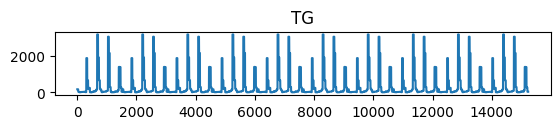

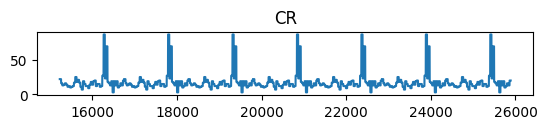

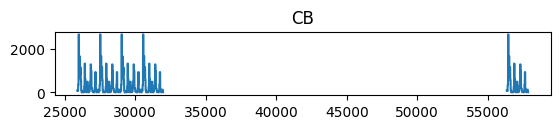

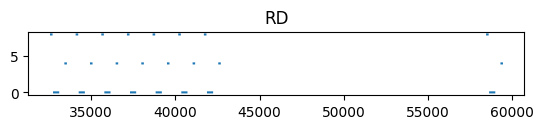

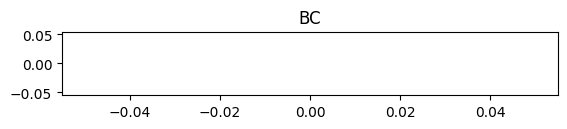

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  train.loc[train.품목명 == item, '수출 금액'].plot()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

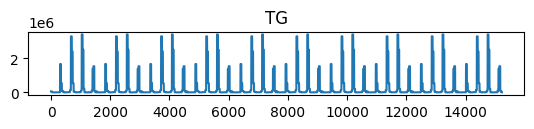

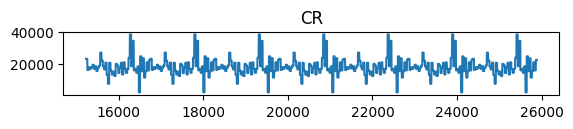

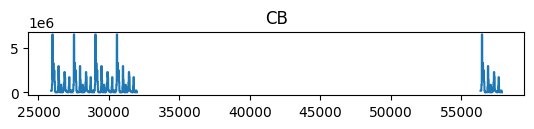

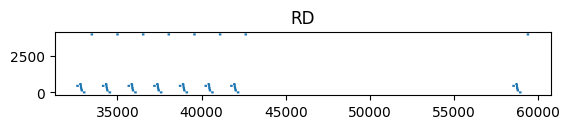

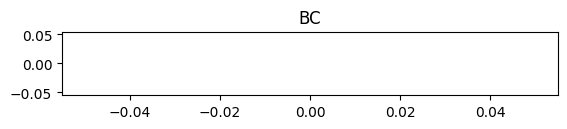

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  train.loc[train.품목명 == item, '수출 중량'].plot()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

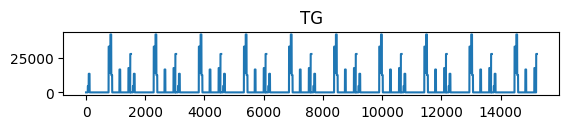

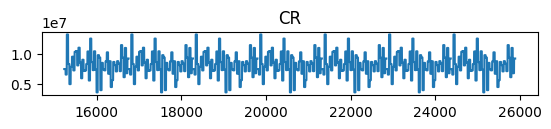

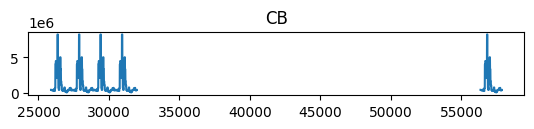

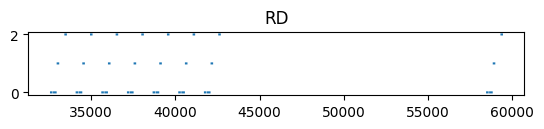

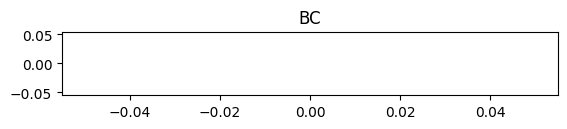

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  train.loc[train.품목명 == item, '수입 중량'].plot()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

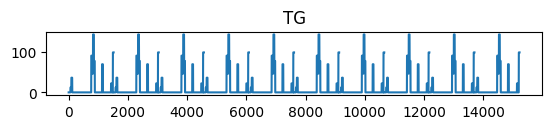

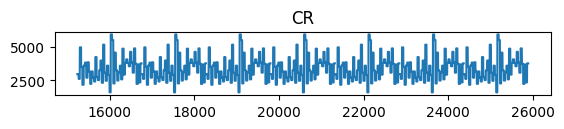

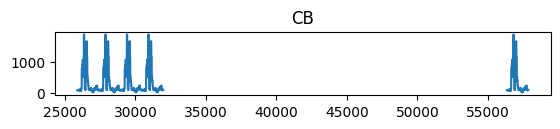

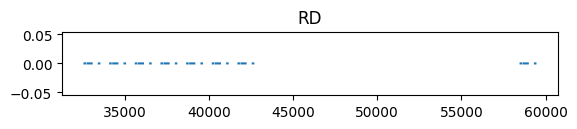

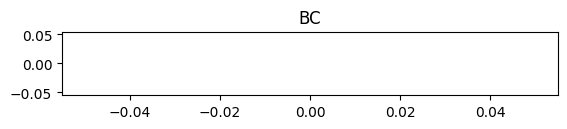

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  train.loc[train.품목명 == item, '수입 금액'].plot()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

In [ ]:
# 금액들간에 연관성을 보기 위함 -> MinMaxScaler 정규화

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['price'] = scaler.fit_transform(train['price'].values.reshape(-1, 1))
scaler = MinMaxScaler()
train['수출 금액'] = scaler.fit_transform(train['수출 금액'].values.reshape(-1, 1))
scaler = MinMaxScaler()
train['수입 금액'] = scaler.fit_transform(train['수입 금액'].values.reshape(-1, 1))

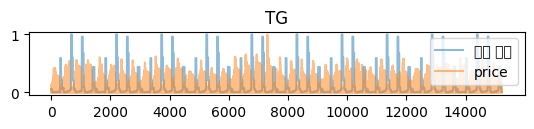

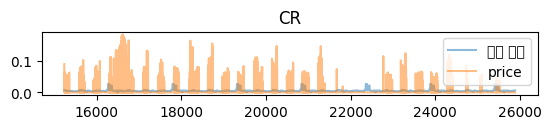

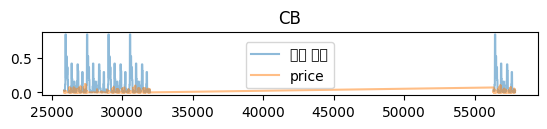

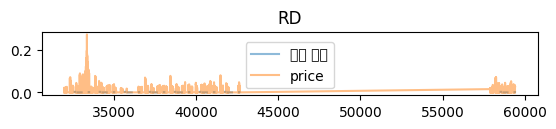

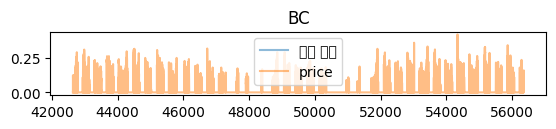

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  plt.plot(train.loc[train.품목명 == item, '수출 금액'], label = '수출 금액', alpha = 0.5)
  plt.plot(train.loc[train.품목명 == item, 'price'], alpha = 0.5, label = 'price')
  plt.legend()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

# 수출 금액과 유통된 품목들의 가격에 대해서 관계성이 보이지 않음.

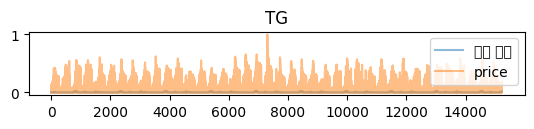

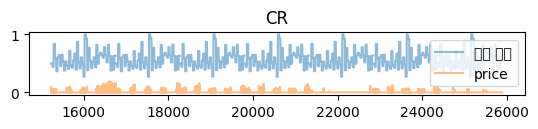

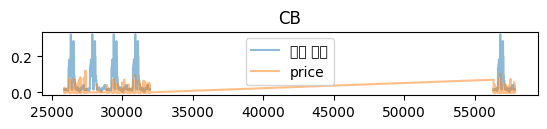

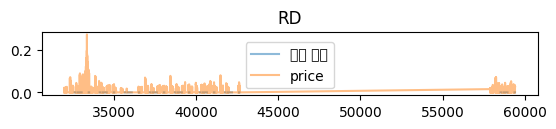

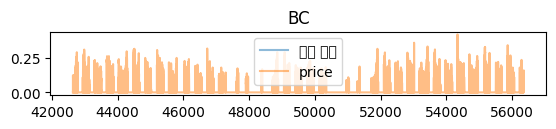

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  plt.plot(train.loc[train.품목명 == item, '수입 금액'], label = '수입 금액', alpha = 0.5)
  plt.plot(train.loc[train.품목명 == item, 'price'], alpha = 0.5, label = 'price')
  plt.legend()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

# 수입 금액과 유통된 품목들의 가격에 대해서 관계성이 보이지 않음.

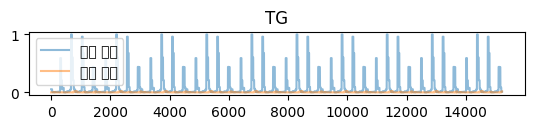

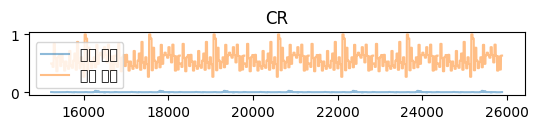

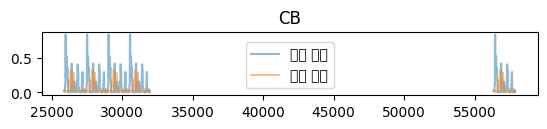

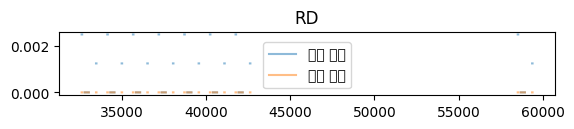

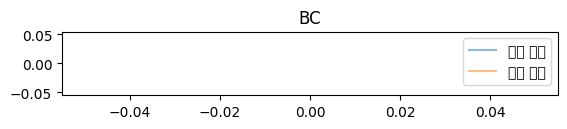

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  plt.plot(train.loc[train.품목명 == item, '수출 금액'], label = '수출 금액', alpha = 0.5)
  plt.plot(train.loc[train.품목명 == item, '수입 금액'], alpha = 0.5, label = '수입 금액')
  plt.legend()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

# 수출 금액과 수입 금액에 대해서 관계성이 보이지 않음.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['supply'] = scaler.fit_transform(train['supply'].values.reshape(-1, 1))
scaler = MinMaxScaler()
train['수출 중량'] = scaler.fit_transform(train['수출 중량'].values.reshape(-1, 1))
scaler = MinMaxScaler()
train['수입 중량'] = scaler.fit_transform(train['수입 중량'].values.reshape(-1, 1))

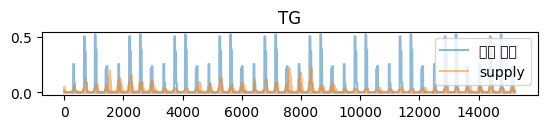

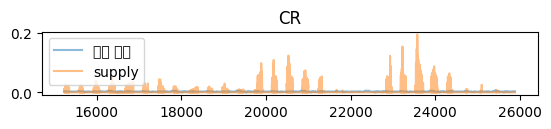

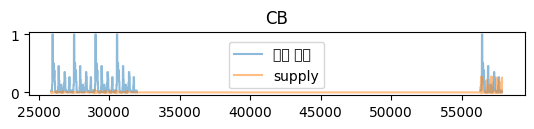

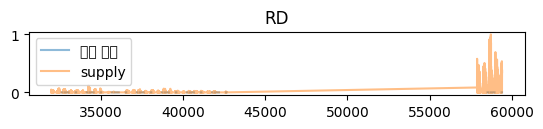

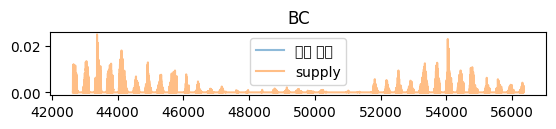

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  plt.plot(train.loc[train.품목명 == item, '수출 중량'], label = '수출 중량', alpha = 0.5)
  plt.plot(train.loc[train.품목명 == item, 'supply'], alpha = 0.5, label = 'supply')
  plt.legend()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

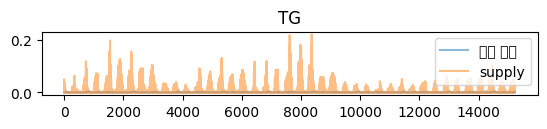

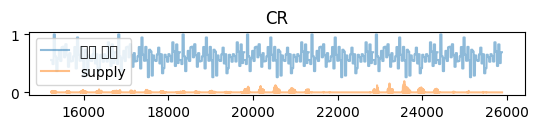

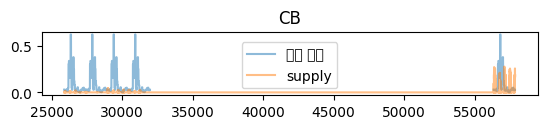

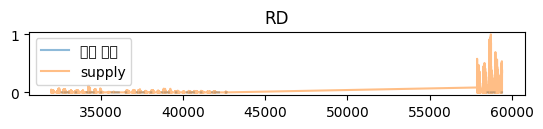

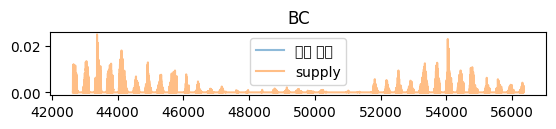

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  plt.plot(train.loc[train.품목명 == item, '수입 중량'], label = '수입 중량', alpha = 0.5)
  plt.plot(train.loc[train.품목명 == item, 'supply'], alpha = 0.5, label = 'supply')
  plt.legend()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

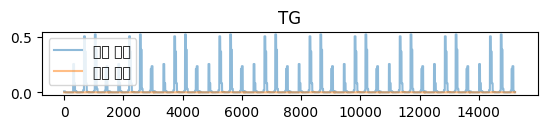

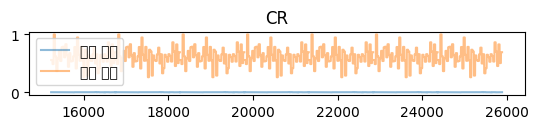

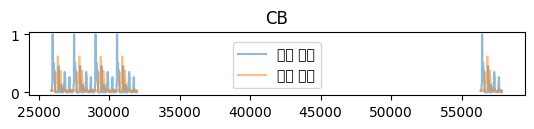

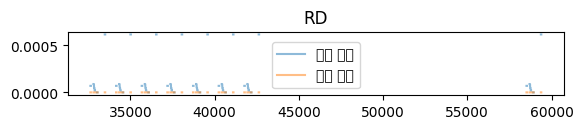

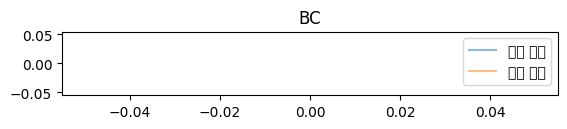

In [ ]:
for i, item in enumerate(train['품목명'].unique()):
  plt.subplot(len(train['품목명'].unique()), 1, i+1)
  plt.plot(train.loc[train.품목명 == item, '수출 중량'], label = '수출 중량', alpha = 0.5)
  plt.plot(train.loc[train.품목명 == item, '수입 중량'], alpha = 0.5, label = '수입 중량')
  plt.legend()
  plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
  plt.show()

In [ ]:
# 눈으로 봤을땐 연관성이 없지만 만약 trade 데이터를 사용해서 모델 성능이 좋았다면 다음과 같은 피처 생성을 고려해볼 수 있음.

# 수출, 수입 변수 생성
train['수출'] = train['수출 금액'] * train['수출 중량']
train['수입'] = train['수입 금액'] * train['수입 중량']

# BC 순무 품목은 trade데이터를 사용할 수 없음
# BC 순무 품목을 제외한 나머지 품목들의 수출, 수입 패턴이 뚜렷해서 trend, seasonal, residual 피처 활용 가능

# 수출 가격과 수입 가격의 차이 변수 생성
# for i, item in enumerate(train['품목명'].unique()):
#   plt.subplot(len(train['품목명'].unique()), 1, i+1)
#   plt.plot(train.loc[train.품목명 == item, '수출 금액'] - train.loc[train.품목명 == item, '수입 금액'])
#   plt.title(train.loc[train['품목명'] == item, 'item'].unique()[0])
#   plt.show()

In [15]:
import requests
import json
from pandas import json_normalize
import warnings

warnings.filterwarnings(action = 'ignore')

In [16]:
key = 'JzOEaocVyAKp%2F%2BAnHTPEHM%2Buf0KYwhiSjfd%2B%2FEN9gxQSWiblmKiErIbRlriXTfUMJoTVFvN%2FjCuKCdJhqjJPiA%3D%3D'

today_year = 2019

url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(today_year) + '&ServiceKey=' + str(key)
response = requests.get(url)
if response.status_code == 200:
	json_ob = json.loads(response.text)
	holidays_data = json_ob['response']['body']['items']['item']
	df_2019 = json_normalize(holidays_data)

today_year = 2020

url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(today_year) + '&ServiceKey=' + str(key)
response = requests.get(url)
if response.status_code == 200:
	json_ob = json.loads(response.text)
	holidays_data = json_ob['response']['body']['items']['item']
	df_2020 = json_normalize(holidays_data)

today_year = 2021

url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(today_year) + '&ServiceKey=' + str(key)
response = requests.get(url)
if response.status_code == 200:
	json_ob = json.loads(response.text)
	holidays_data = json_ob['response']['body']['items']['item']
	df_2021 = json_normalize(holidays_data)

today_year = 2022

url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(today_year) + '&ServiceKey=' + str(key)
response = requests.get(url)
if response.status_code == 200:
	json_ob = json.loads(response.text)
	holidays_data = json_ob['response']['body']['items']['item']
	df_2022 = json_normalize(holidays_data)


today_year = 2023

url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(today_year) + '&ServiceKey=' + str(key)
response = requests.get(url)
if response.status_code == 200:
	json_ob = json.loads(response.text)
	holidays_data = json_ob['response']['body']['items']['item']
	df_2023 = json_normalize(holidays_data)

In [17]:
df_holiday = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], axis = 0)
df_holiday.drop(['dateKind', 'dateName', 'seq'], axis = 1, inplace= True)

In [18]:
df_holiday = df_holiday.rename(columns = {'locdate':'date'})
df_holiday.date = df_holiday.date.astype(str)
df_holiday.date = pd.to_datetime(df_holiday['date'], format='%Y-%m-%d')

In [19]:
df_holiday

isHoliday       date
0          Y 2019-01-01
1          Y 2019-02-04
2          Y 2019-02-05
3          Y 2019-02-06
4          Y 2019-03-01
..       ...        ...
13         Y 2023-09-30
14         Y 2023-10-02
15         Y 2023-10-03
16         Y 2023-10-09
17         Y 2023-12-25

[89 rows x 2 columns]

In [20]:
## date 정보 생성
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

In [21]:
train = pd.merge(train, df_holiday, on = 'date', how = 'left')
test = pd.merge(test, df_holiday, on = 'date', how = 'left')

In [22]:
train[train.isHoliday != 'Y'].groupby(['item'])['price'].max()

item
BC     8750.0
CB     2500.0
CR     3882.0
RD     5715.0
TG    20909.0
Name: price, dtype: float64

In [23]:
train[train.isHoliday == 'Y'].groupby(['item'])['price'].max()

item
BC     5062.0
CB     2189.0
CR     2900.0
RD     1375.0
TG    14500.0
Name: price, dtype: float64

근데 휴일 부분과 휴일이 아닌 부분에 대해 가격 평균을 비교했을때

휴일이 아닌 부분이 휴일인 부분에 비해 비교적으로 큰 경향이 있음

휴일 부분에 대한 처리가 필요!

In [24]:
# 휴일 전 후 smoothing

holidays = train[train.isHoliday == 'Y'].index
for index in holidays:
  if index > train.index[0] and index < train.index[-1]:
    prev_index = index - 1
    next_index = index + 1

    while train.loc[prev_index, 'isHoliday'] == 'Y':
      prev_index -= 1

    while train.loc[next_index, 'isHoliday'] == 'Y':
      next_index += 1

    average_supply = (train.loc[prev_index, 'supply'] + train.loc[next_index, 'supply'])/2
    average_price = (train.loc[prev_index, 'price'] + train.loc[next_index, 'price'])/2
    #next_supply = train.loc[next_index, 'supply']
    #next_price = train.loc[next_index, 'price']
    train.loc[index, 'supply'] = average_supply
    train.loc[index, 'price'] = average_price

In [25]:
train.drop(['isHoliday'], axis = 1, inplace = True)
test.drop(['isHoliday'], axis = 1, inplace = True)

#train.drop(['품목명',	'기간',	'수출 중량',	'수출 금액',	'수입 중량',	'수입 금액',	'무역수지'], axis = 1, inplace = True)

In [26]:
train_date = pd.DataFrame(train['date'].unique(), columns=['date'])
test_date = pd.DataFrame(test['date'].unique(), columns=['date'])

#train_date['year'] = train_date['date'].dt.year
train_date['month'] = train_date['date'].dt.month
#train_date['year_month'] = train_date['date'].dt.to_period('M')
#train_date['day'] = train_date['date'].dt.day
train_date['weekday'] = train_date['date'].dt.weekday
#train_date['weekend'] = train_date['weekday'].apply(lambda x: 1 if x >= 5 else 0)
# train_date['friday'] = train_date['weekday'].apply(lambda x: 1 if x == 5 else 0)

# test_date['year'] = test_date['date'].dt.year
test_date['month'] = test_date['date'].dt.month
#test_date['year_month'] = test_date['date'].dt.to_period('M')
#test_date['day'] = test_date['date'].dt.day
test_date['weekday'] = test_date['date'].dt.weekday
#test_date['weekend'] = test_date['weekday'].apply(lambda x: 1 if x >= 5 else 0)
# test_date['friday'] = test_date['weekday'].apply(lambda x: 1 if x == 5 else 0)

# 날짜 데이터를 가지고 -> 쿼터(분기)별
train_date['quarter'] = train_date['date'].dt.quarter
test_date['quarter'] = test_date['date'].dt.quarter

train_date.index = train_date['date']
test_date.index = test_date['date']

train_date.drop(columns=['date'], inplace=True)
test_date.drop(columns=['date'], inplace=True)

감귤 같은 품목에 경우 계절적인 요소에 영향을 받음

In [27]:
# 계절 변수 생성
def Calculate_Season(month):
  if 3 <= month <= 5:
    season = 0 #'봄'
  elif 6 <= month <= 8:
    season = 1 #'여름'
  elif 9 <= month <= 11:
    season = 2 #'가을'
  else:
    season = 3 #'겨울'

  return season

# train_date['season'] = train_date['month'].apply(Calculate_Season)
# test_date['season'] = test_date['month'].apply(Calculate_Season)

In [ ]:
# train_date.drop(['month'], axis = 1, inplace = True)
# test_date.drop(['month'], axis = 1, inplace = True)

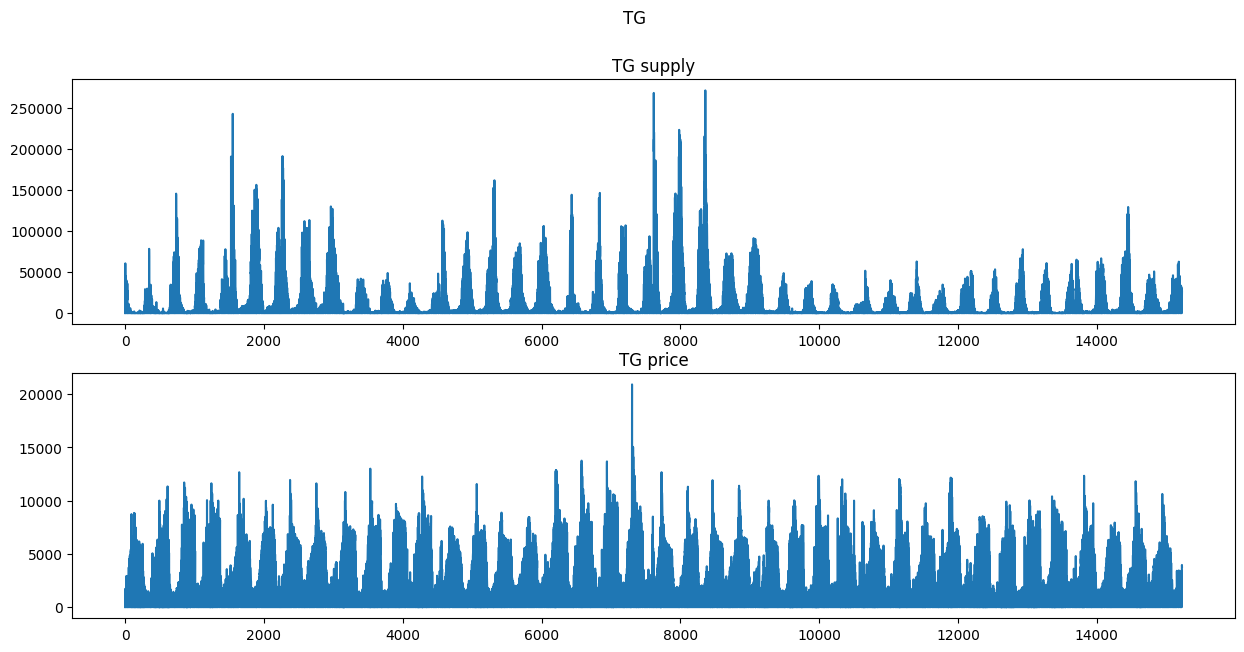

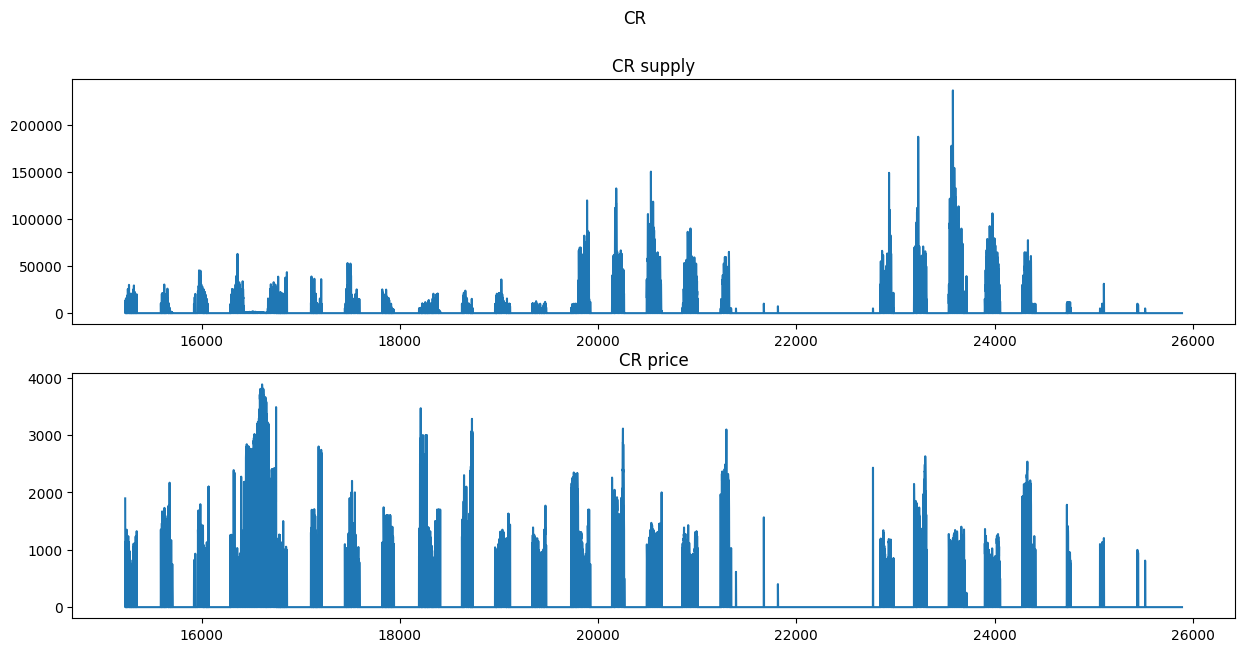

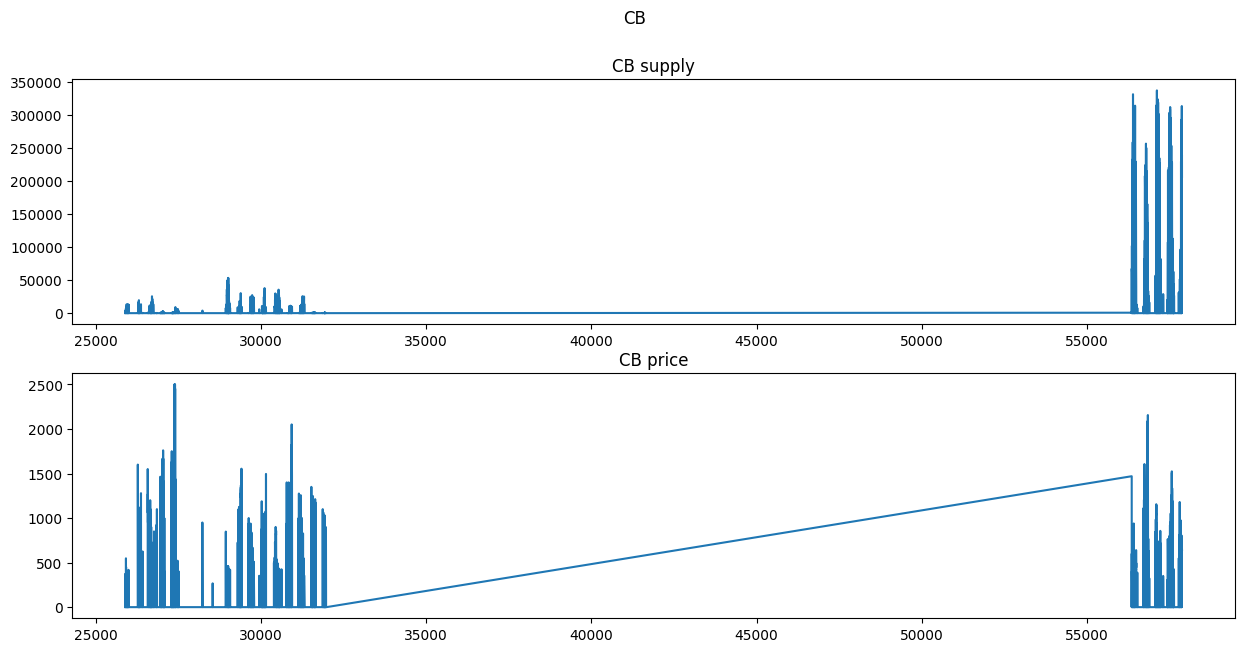

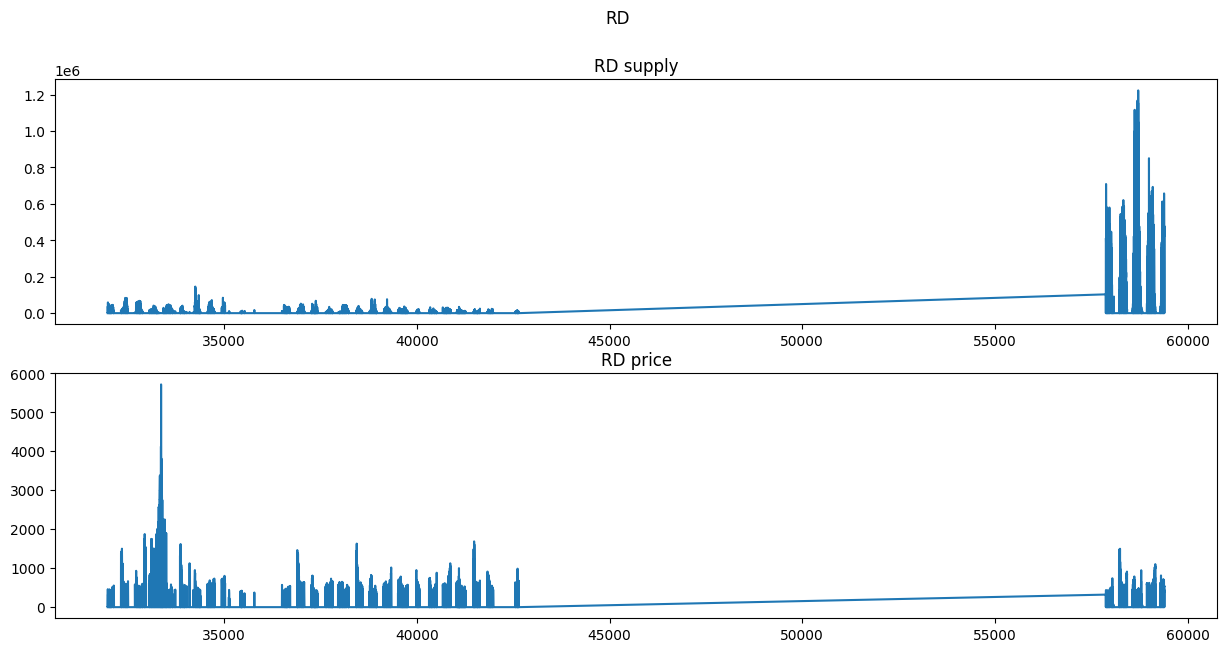

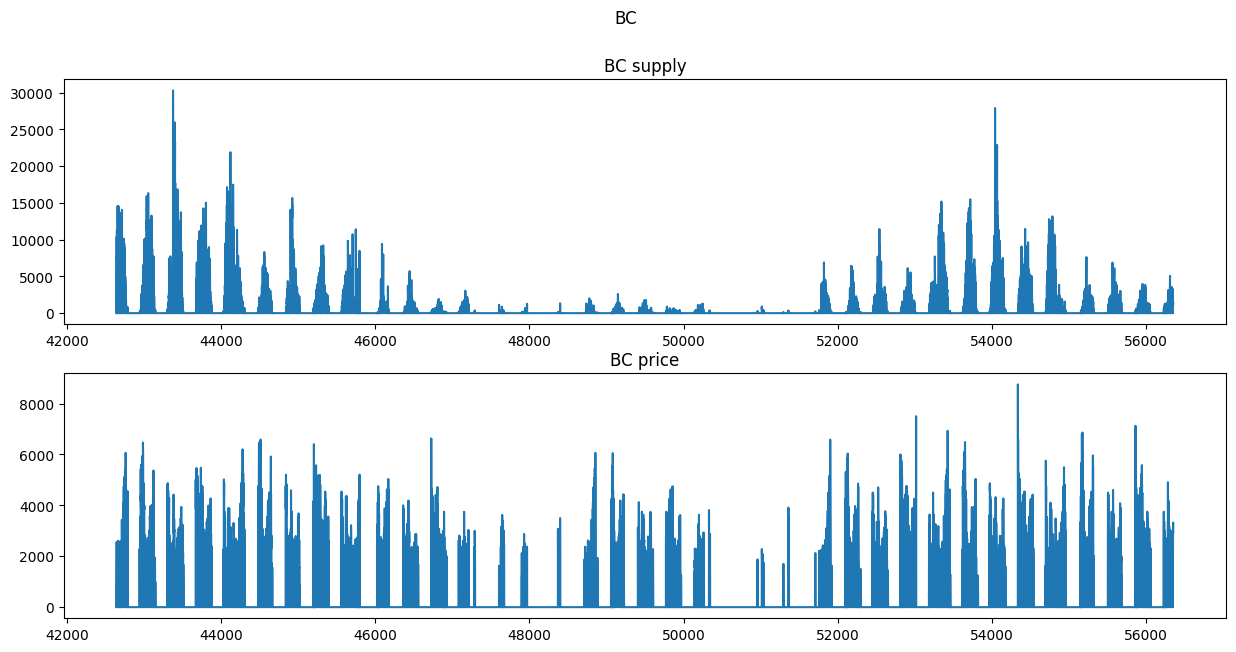

In [ ]:
for item in train.item.unique():
  plt.figure(figsize = (15, 7))
  plt.subplot(2, 1, 1)
  train.loc[train.item == item, 'supply'].plot()
  plt.title(f'{item} supply')
  plt.subplot(2, 1, 2)
  train.loc[train.item == item, 'price'].plot()
  plt.title(f'{item} price')
  plt.suptitle(f'{item}')

품목별로 다른 분포를 보임
- 따라서 품목별 모델링을 하면 좋을것으로 예상

In [28]:
# supply가 0인데 price에 값이 존재 -> 학습 도움 x
train.loc[train['price'] == 0, 'supply'].value_counts()
train.loc[(train['price'] == 0)&(train['supply'] != 0)]

date item corporation location  supply  price
825   2021-04-05   TG           A        J    64.0    0.0
9266  2019-05-09   TG           D        J   129.0    0.0
31199 2021-01-09   CB           E        J    80.0    0.0

In [29]:
train.loc[(train['price'] == 0)&(train['supply'] != 0)]

date item corporation location  supply  price
825   2021-04-05   TG           A        J    64.0    0.0
9266  2019-05-09   TG           D        J   129.0    0.0
31199 2021-01-09   CB           E        J    80.0    0.0

In [30]:
train.loc[(train['price'] == 0)&(train['supply'] != 0), ['price', 'supply']] = 0 # 0으로 채움

In [31]:
pivot_train = train.pivot_table(index = ['date'], columns = ['item', 'corporation', 'location'], values = 'price')
pivot_train.columns = [f'{item}_{corporation}_{location}_price' for (item, corporation, location) in pivot_train.columns]

pivot_train_sp = train.pivot_table(index = ['date'], columns = ['item', 'corporation', 'location'], values = 'supply')
pivot_train_sp.columns = [f'{item}_{corporation}_{location}_supply' for (item, corporation, location) in pivot_train_sp.columns]

In [37]:
train_date.index = train_date.index.astype(str)

In [38]:
pivot_train.index = pd.to_datetime(pivot_train.index).astype(str)

In [39]:
pivot_train = pd.merge(pivot_train, train_date, on = 'date', how = 'left')

In [40]:
pivot_train

BC_A_J_price  BC_A_S_price  BC_B_J_price  BC_B_S_price  \
date                                                                 
2019-01-01           0.0        1425.0        1437.5        1279.0   
2019-01-02           0.0           0.0           0.0           0.0   
2019-01-03        2559.0        2188.0        2440.0           0.0   
2019-01-04        2425.0        2455.0        2348.0           0.0   
2019-01-05        2097.0        2242.0        2100.0           0.0   
...                  ...           ...           ...           ...   
2023-02-27        2357.0        2378.0        2610.0           0.0   
2023-02-28        3307.0        3218.0        3035.0           0.0   
2023-03-01        3121.5        3142.5        2860.0           0.0   
2023-03-02        2936.0        3067.0        2685.0           0.0   
2023-03-03        2850.0        2875.0        2558.0           0.0   

            BC_C_J_price  BC_C_S_price  BC_D_J_price  BC_E_J_price  \
date                                                                 
2019-01-01           0.0        1467.0           0.0        1529.5   
2019-01-02           0.0           0.0           0.0           0.0   
2019-01-03        2079.0           0.0        2253.0        2379.0   
2019-01-04        2020.0           0.0        2175.0        2257.0   
2019-01-05        1849.0        1625.0        1981.0        1857.0   
...                  ...           ...           ...           ...   
2023-02-27        1859.0           0.0        2473.0        2492.0   
2023-02-28        2873.0           0.0        2896.0        3480.0   
2023-03-01        2471.5           0.0        3040.5        3312.0   
2023-03-02        2070.0           0.0        3185.0        3144.0   
2023-03-03        2934.0           0.0        3059.0        3045.0   

            BC_E_S_price  CB_A_J_price  ...  TG_B_S_price  TG_C_J_price  \
date                                    ...                               
2019-01-01        1522.5           0.0  ...        1735.0        2120.5   
2019-01-02           0.0           0.0  ...           0.0           0.0   
2019-01-03           0.0           0.0  ...        1944.0        1965.0   
2019-01-04        2301.0           0.0  ...        1815.0        1794.0   
2019-01-05        1880.0         374.0  ...        1717.0        1773.0   
...                  ...           ...  ...           ...           ...   
2023-02-27        2488.0        1438.0  ...        4057.0        5037.0   
2023-02-28        3232.0         710.0  ...        3821.0        2643.0   
2023-03-01        3276.5        1011.0  ...        3912.5        3313.0   
2023-03-02        3321.0        1312.0  ...        4004.0        3983.0   
2023-03-03        2939.0           0.0  ...        4241.0        5175.0   

            TG_C_S_price  TG_D_J_price  TG_D_S_price  TG_E_J_price  \
date                                                                 
2019-01-01        2587.5        2374.0           0.0        2073.0   
2019-01-02           0.0           0.0           0.0           0.0   
2019-01-03        2078.0        1616.0        2048.0        1692.0   
2019-01-04        2002.0        1337.0        1757.0        1475.0   
2019-01-05        1815.0        1234.0        1719.0        1392.0   
...                  ...           ...           ...           ...   
2023-02-27        4180.0           0.0        3409.0        2620.0   
2023-02-28        4234.0           0.0        3236.0        1673.0   
2023-03-01        4350.0           0.0        3675.0        1788.5   
2023-03-02        4466.0           0.0        4114.0        1904.0   
2023-03-03        4748.0           0.0        4146.0        1622.0   

            TG_E_S_price  month  weekday  quarter  
date                                               
2019-01-01         811.0      1        1        1  
2019-01-02           0.0      1        2        1  
2019-01-03        2151.0      1        3        1  
2019-01-04        1829.0      1        4   

In [41]:
train.item.value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [42]:
itemname = 'TG'

In [43]:
for pivot in pivot_train.columns[pivot_train.columns.str.contains(itemname)]:
  temp = pivot_train[pivot_train[pivot] == 0]
  stacked_temp = temp.stack()

In [44]:
stacked_temp

date                    
2019-01-02  BC_A_J_price    0.0
            BC_A_S_price    0.0
            BC_B_J_price    0.0
            BC_B_S_price    0.0
            BC_C_J_price    0.0
                           ... 
2023-02-26  TG_E_J_price    0.0
            TG_E_S_price    0.0
            month           2.0
            weekday         6.0
            quarter         1.0
Length: 10920, dtype: float64

In [45]:
stacked_temp_dup = stacked_temp[stacked_temp.duplicated(keep = False)].index
stacked_temp_notdup = stacked_temp[~stacked_temp.duplicated(keep = False)].index

In [46]:
stacked_temp_dup_set = set(stacked_temp_dup.get_level_values('date'))

In [47]:
stacked_temp_notdup_set = set(stacked_temp_notdup.get_level_values('date'))

In [48]:
#stacked_temp_dup_set, stacked_temp_notdup_set

In [49]:
train_date.index = train_date.index.astype(str)

In [50]:
pivot_temp_dup_merged = pivot_train[pivot_train.index.isin(stacked_temp_dup_set)]

In [51]:
pivot_temp_dup_merged.weekday.value_counts()

6    203
5     14
1     11
3     11
4      8
0      7
2      6
Name: weekday, dtype: int64

In [52]:
containscolumns = pivot_train.columns[pivot_train.columns.str.contains(itemname) | pivot_train.columns.str.contains('month')]

In [53]:
containscolumns

Index(['TG_A_J_price', 'TG_A_S_price', 'TG_B_J_price', 'TG_B_S_price',
       'TG_C_J_price', 'TG_C_S_price', 'TG_D_J_price', 'TG_D_S_price',
       'TG_E_J_price', 'TG_E_S_price', 'month'],
      dtype='object')

In [54]:
pivot_temp_dup_merged_find = pivot_temp_dup_merged.loc[pivot_temp_dup_merged.weekday != 6, containscolumns] # test데이터의 기간은 3월

# TG
# 2019-03-28 말고는 0이 중복되는 곳이 없다?
#TG_D_J_price, TG_E_J_price, TG_E_S_price에 대해서만 0으로 중복

In [55]:
# 2021-03-19?

In [56]:
pivot_temp_dup_merged_find

TG_A_J_price  TG_A_S_price  TG_B_J_price  TG_B_S_price  \
date                                                                 
2019-01-02           0.0           0.0           0.0           0.0   
2019-02-04           0.0           0.0           0.0           0.0   
2019-02-05           0.0           0.0           0.0           0.0   
2019-02-06           0.0           0.0           0.0           0.0   
2019-02-07           0.0           0.0           0.0           0.0   
2019-03-28        6215.0        5056.0        6061.0        4066.0   
2019-04-03        2533.0        4541.0        5866.0        4556.0   
2019-04-08           0.0        4916.0        6383.0           0.0   
2019-04-11        6667.0        8653.0           0.0        7426.0   
2019-04-13        6667.0        6112.0           0.0        5579.0   
2019-04-15           0.0        5325.0        8000.0        6076.0   
2019-04-16           0.0        4400.0           0.0        6303.0   
2019-04-17           0.0        5091.0        8000.0        5706.0   
2019-04-18           0.0        6780.0           0.0        5616.0   
2019-04-19        2917.0        4967.0        4591.0        4724.0   
2019-04-20           0.0        5371.0           0.0        4392.0   
2019-04-23        3926.0        3495.0        2672.0        5454.0   
2019-04-26           0.0        4840.0           0.0        4559.0   
2019-04-27           0.0        3757.0           0.0        4597.0   
2019-04-29           0.0        6019.0           0.0        4602.0   
2019-04-30           0.0        5109.0        3933.0        6675.0   
2019-05-01        3837.0       12665.0           0.0        3752.0   
2019-05-02           0.0        6520.0       10000.0        6077.0   
2019-08-03           0.0           0.0           0.0           0.0   
2019-08-06           0.0        5388.0        6902.0        5677.0   
2020-01-02           0.0           0.0           0.0           0.0   
2020-04-25        3838.0        6851.0           0.0        4461.0   
2020-05-14        8694.0        8497.0        5102.0        7822.0   
2020-05-23           0.0        8633.0        9026.0        7930.0   
2020-08-01           0.0           0.0           0.0           0.0   
2021-01-02           0.0           0.0           0.0           0.0   
2021-05-01       10733.0        6564.0           0.0           0.0   
2021-05-14        9000.0        9909.0        8011.0        6993.0   
2021-06-01           0.0        7816.0        8802.0        6561.0   
2021-06-03        9909.0        6985.0        8302.0        6263.0   
2021-06-04           0.0        7004.0        8830.0        6496.0   
2021-06-19        7079.0        6302.0        8427.0        5506.0   
2021-06-21           0.0        6676.0        8530.0        5904.0   
2021-06-22        8873.0        6551.0        8224.0        6074.0   
2021-06-25        6793.0        6599.0        8052.0        6387.0   
2021-07-03        7270.0        6673.0        8006.0        6060.0   
2021-07-06        8200.0        6010.0        8261.0        5823.0   
2021-07-13        5754.0        5761.0        8305.0        5170.0   
2021-07-16        8208.0        6594.0        6201.0        5066.0   
2021-07-27        7212.0        5722.0        7909.0        4994.0   
2021-08-06           0.0        6516.0           0.0        6331.0   
2021-08-07           0.0           0.0           0.0           0.0   
2021-08-12        7443.0        5616.0        6056.0        5240.0   
2021-08-13        9627.0        5231.0        7922.0        5740.0   
2021-08-14        7667.0        6142.0        7333.0        4834.0   
2021-09-20           0.0           0.0           0.0           0.0   
2021-09-21           0.0           0.0           0.0           0.0   
2021-09-22           0.0           0.0           0.0           0.0   
2021-09-23           0.0           0.0           0.0           0.0   
2022-02-03           0.0           0.0           0.0           0.0   
2022-08-06           0

In [57]:
pivot_temp_dup_merged_find[pivot_temp_dup_merged_find.month == 3]

TG_A_J_price  TG_A_S_price  TG_B_J_price  TG_B_S_price  \
date                                                                 
2019-03-28        6215.0        5056.0        6061.0        4066.0   

            TG_C_J_price  TG_C_S_price  TG_D_J_price  TG_D_S_price  \
date                                                                 
2019-03-28        7329.0        5660.0           0.0        5945.0   

            TG_E_J_price  TG_E_S_price  month  
date                                           
2019-03-28           0.0           0.0      3

In [58]:
a = pivot_temp_dup_merged_find.loc[pivot_temp_dup_merged_find.month == 3, containscolumns[:-1]]
a[(a == 0).all(axis = 1)]

Empty DataFrame
Columns: [TG_A_J_price, TG_A_S_price, TG_B_J_price, TG_B_S_price, TG_C_J_price, TG_C_S_price, TG_D_J_price, TG_D_S_price, TG_E_J_price, TG_E_S_price]
Index: []

In [59]:
pivot_temp_notdup_merged = pivot_train[pivot_train.index.isin(stacked_temp_notdup_set)]

In [60]:
pivot_temp_notdup_merged.weekday.value_counts() # tg, rd weekday가 6일때 중복되는 패턴이 발생하고

5    9
1    9
4    8
3    7
0    4
2    3
Name: weekday, dtype: int64

In [ ]:
pivot_train.head(), pivot_train_sp.head()

(            BC_A_J_price  BC_A_S_price  BC_B_J_price  BC_B_S_price  \
 date                                                                 
 2019-01-01           0.0        1425.0        1437.5        1279.0   
 2019-01-02           0.0           0.0           0.0           0.0   
 2019-01-03        2559.0        2188.0        2440.0           0.0   
 2019-01-04        2425.0        2455.0        2348.0           0.0   
 2019-01-05        2097.0        2242.0        2100.0           0.0   
 
             BC_C_J_price  BC_C_S_price  BC_D_J_price  BC_E_J_price  \
 date                                                                 
 2019-01-01           0.0        1467.0           0.0        1529.5   
 2019-01-02           0.0           0.0           0.0           0.0   
 2019-01-03        2079.0           0.0        2253.0        2379.0   
 2019-01-04        2020.0           0.0        2175.0        2257.0   
 2019-01-05        1849.0        1625.0        1981.0        1857.0   
 
  

In [ ]:
def supply_price_plot(price_pivot, supply_pivot, item_name, redline):
  item_name_included = price_pivot.columns[price_pivot.columns.str.contains(item_name)].str[:-6]
  plt.figure(figsize = (20, 5))
  axvline2019 = price_pivot.loc[price_pivot.index == '2019-01-01'].index
  axvline2020 = price_pivot.loc[price_pivot.index == '2020-01-01'].index
  axvline2021 = price_pivot.loc[price_pivot.index == '2021-01-01'].index
  axvline2022 = price_pivot.loc[price_pivot.index == '2022-01-01'].index
  axvline2023 = price_pivot.loc[price_pivot.index == '2023-01-01'].index
  max_value = 0.0
  for idx, col in enumerate(item_name_included):
    plt.plot(price_pivot.index, price_pivot[f'{col}_price'], label = f'{col}_price', alpha = 0.5)
    plt.plot(supply_pivot.index, supply_pivot[f'{col}_supply'], label = f'{col}_supply', alpha = 0.5)
    if max_value < max(price_pivot[f'{col}_price']):
      max_value = max(price_pivot[f'{col}_price'])
    if redline:
      plt.axvline(axvline2019, 0, max_value, color = 'red', linestyle = '--', linewidth = 2)
      plt.axvline(axvline2020, 0, max_value, color = 'red', linestyle = '--', linewidth = 2)
      plt.axvline(axvline2021, 0, max_value, color = 'red', linestyle = '--', linewidth = 2)
      plt.axvline(axvline2022, 0, max_value, color = 'red', linestyle = '--', linewidth = 2)
      plt.axvline(axvline2023, 0, max_value, color = 'red', linestyle = '--', linewidth = 2)
    plt.title(f'{col} supply & price Relation')
    plt.xticks([])
    plt.legend()
    plt.show()

In [ ]:
train[train['isHoliday'] == 'Y']

date item corporation location    supply   price 품목명       기간  \
0     2019-01-01   TG           A        J       0.0     0.0  감귤  2019-01   
34    2019-02-04   TG           A        J       0.0     0.0  감귤  2019-02   
35    2019-02-05   TG           A        J       0.0     0.0  감귤  2019-02   
36    2019-02-06   TG           A        J       0.0     0.0  감귤  2019-02   
59    2019-03-01   TG           A        J    3753.5  4189.5  감귤  2019-03   
...          ...  ...         ...      ...       ...     ...  ..      ...   
59355 2023-01-21   RD           F        J  269550.0   549.0  순무  2023-01   
59356 2023-01-22   RD           F        J  269550.0   549.0  순무  2023-01   
59357 2023-01-23   RD           F        J  269550.0   549.0  순무  2023-01   
59358 2023-01-24   RD           F        J  269550.0   549.0  순무  2023-01   
59394 2023-03-01   RD           F        J  449600.0   527.0  순무  2023-03   

         수출 중량  수출 금액   수입 중량  수입 금액   무역수지          수출       수입 isHoliday  
0      58368.0  172.0     0.0    0.0  172.0  10039296.0      0.0         Y  
34      8474.0   33.0     0.0    0.0   33.0    279642.0      0.0         Y  
35      8474.0   33.0     0.0    0.0   33.0    279642.0      0.0         Y  
36      8474.0   33.0     0.0    0.0   33.0    279642.0      0.0         Y  
59      2061.0   10.0  4599.0   12.0   -2.0     20610.0  55188.0         Y  
...        ...    ...     ...    ...    ...         ...      ...       ...  
59355      NaN    NaN     NaN    NaN    NaN         NaN      NaN         Y  
59356      NaN    NaN     NaN    NaN    NaN         NaN      NaN         Y  
59357      NaN    NaN     NaN    NaN    NaN         NaN      NaN         Y  
59358      NaN    NaN     NaN    NaN    NaN         NaN      NaN         Y  
59394      NaN    NaN     NaN    NaN    NaN         NaN      NaN         Y  

[3003 rows x 16 columns]

TG


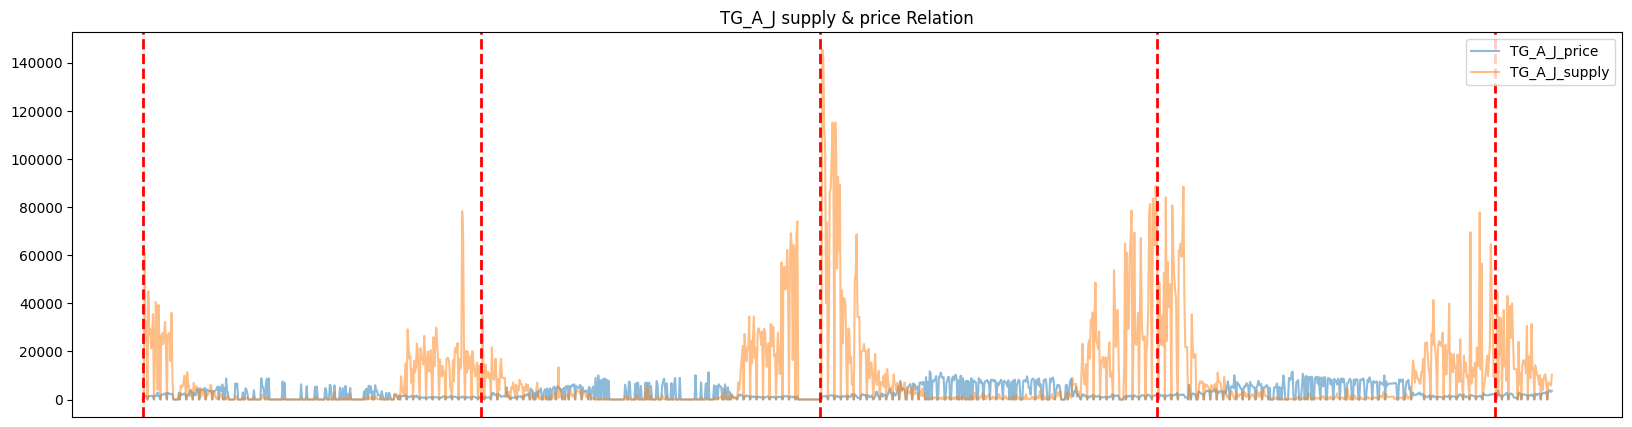

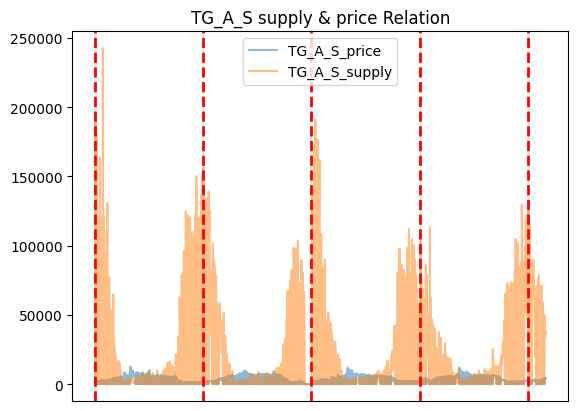

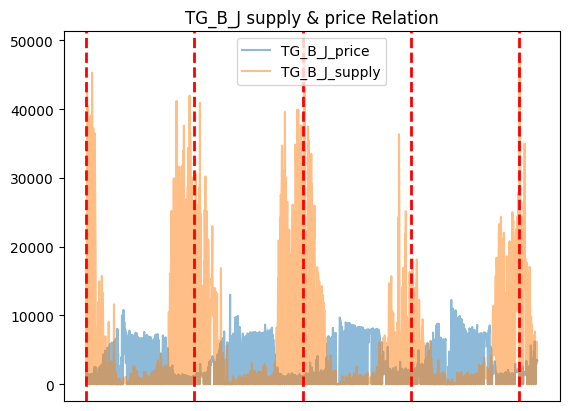

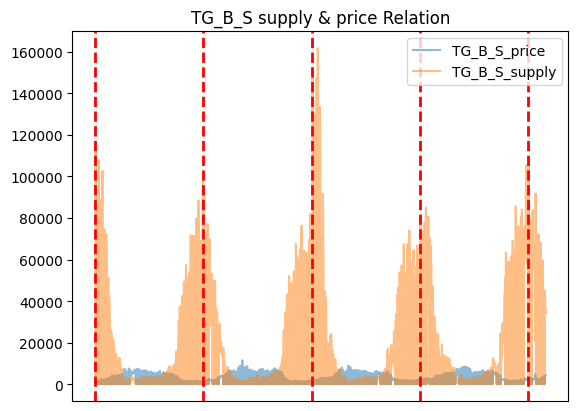

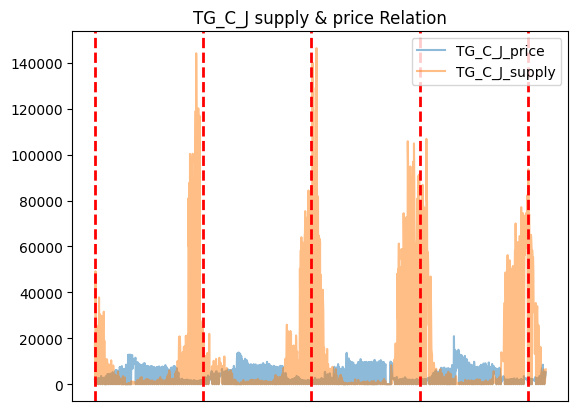

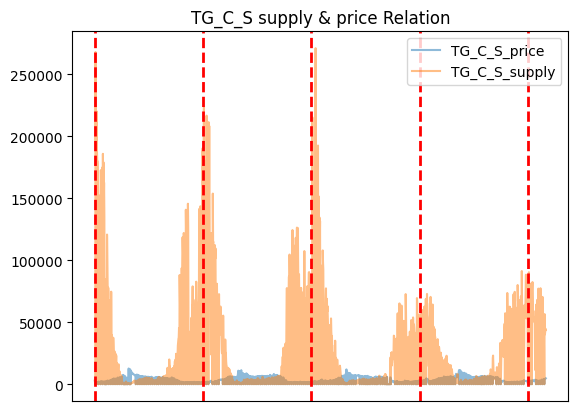

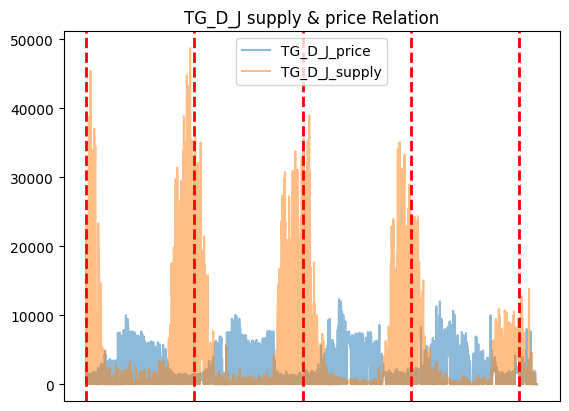

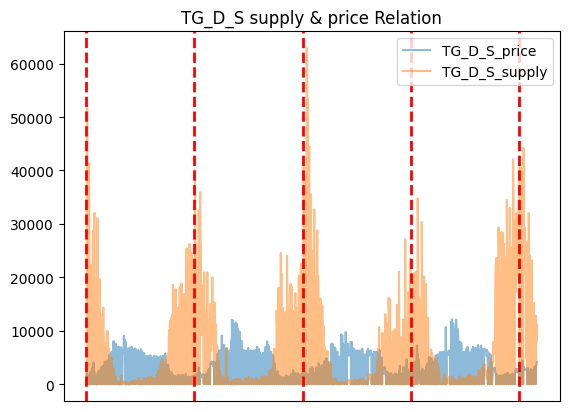

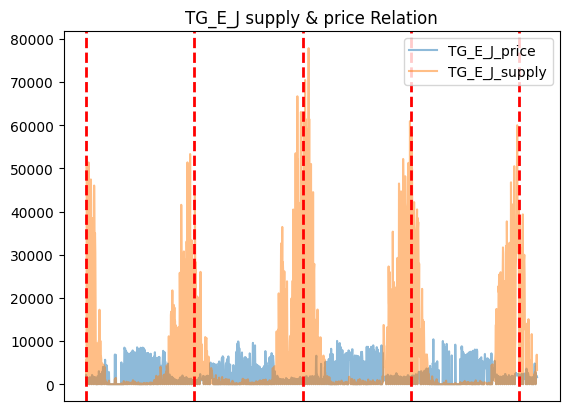

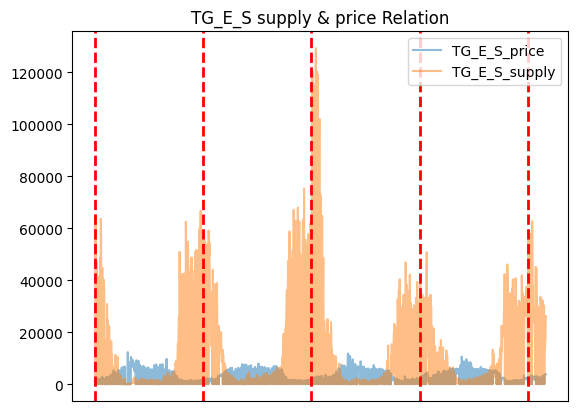

CR


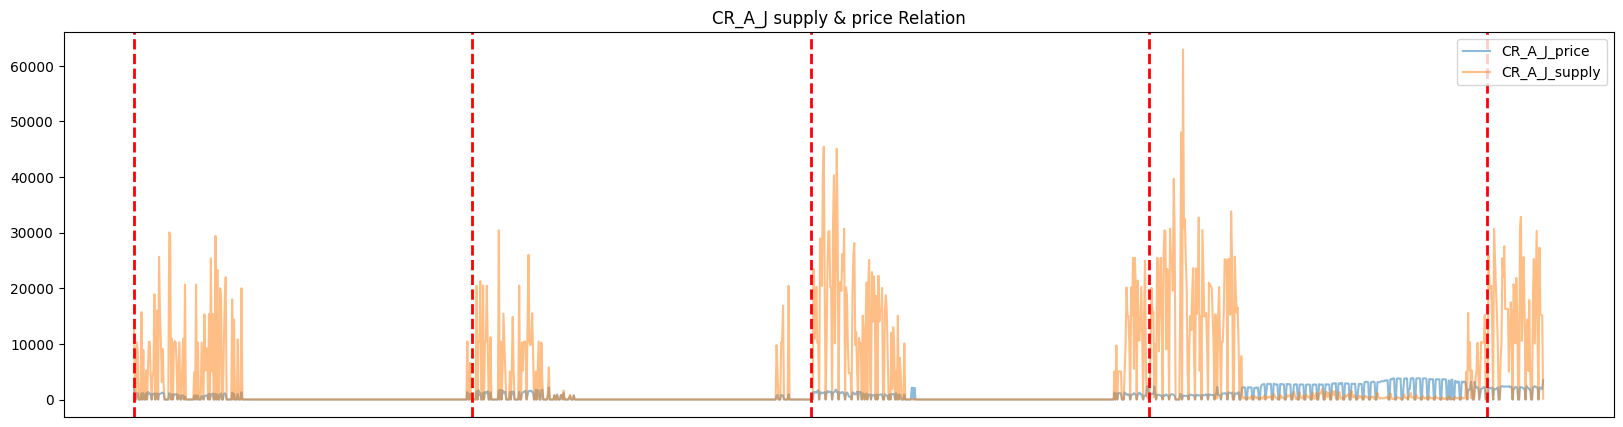

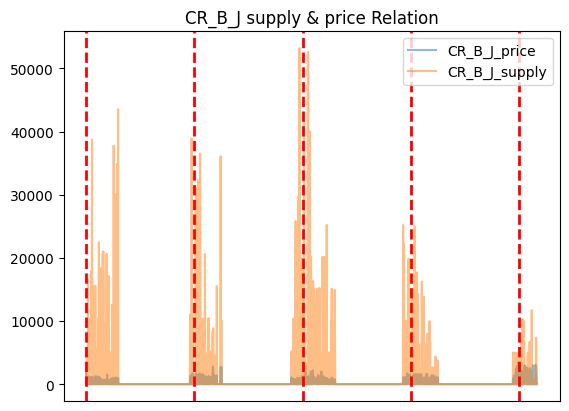

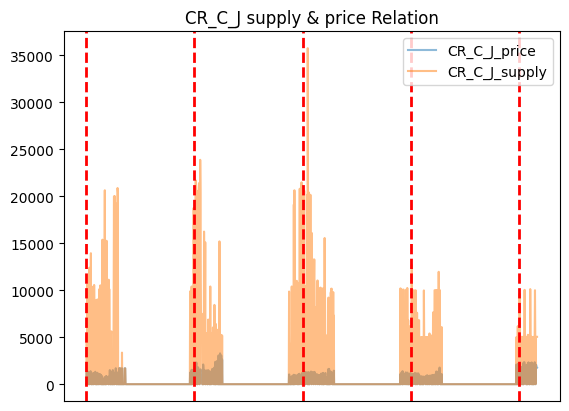

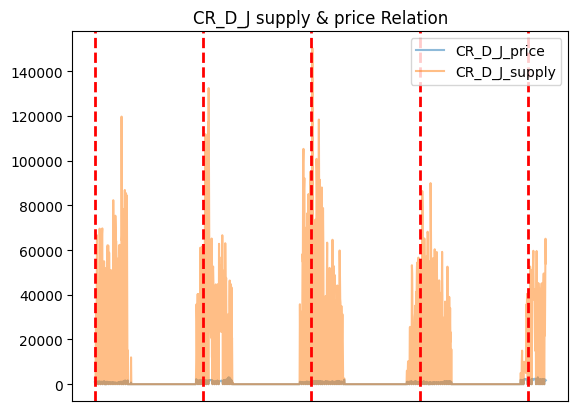

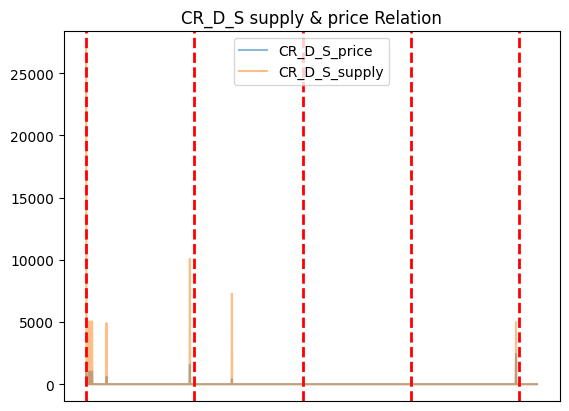

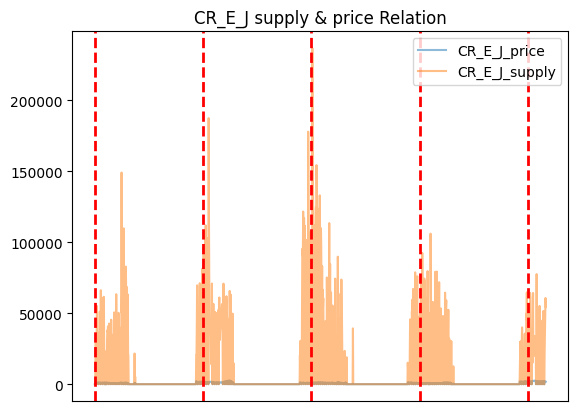

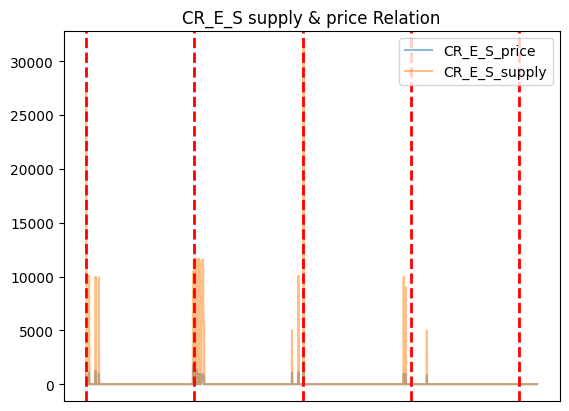

CB


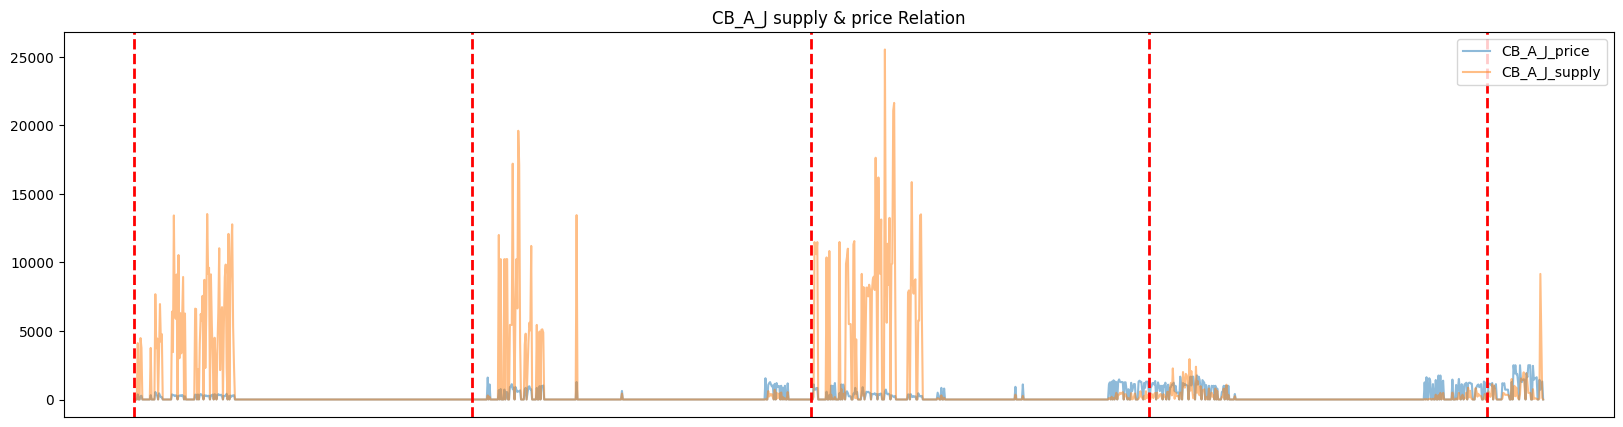

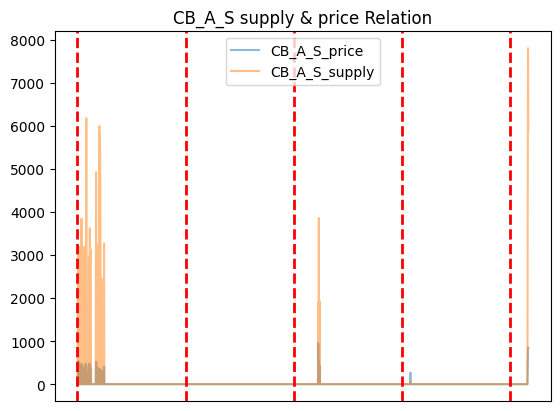

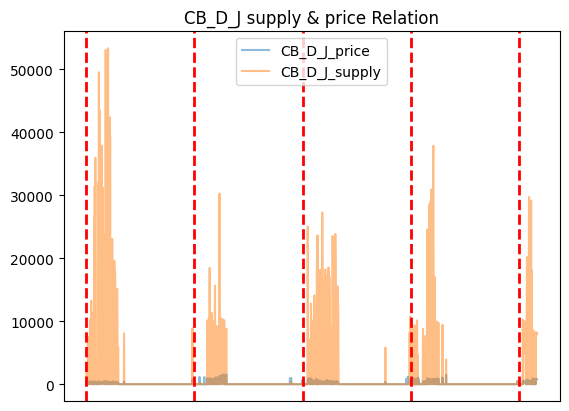

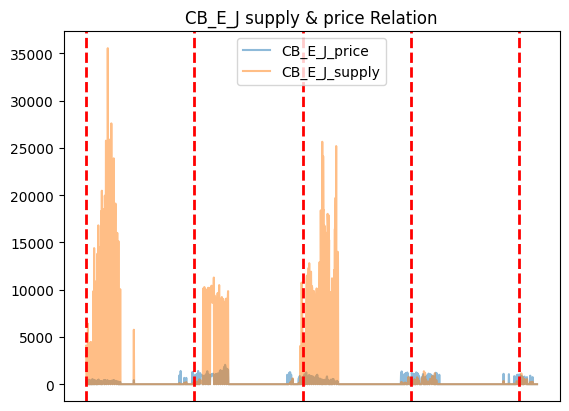

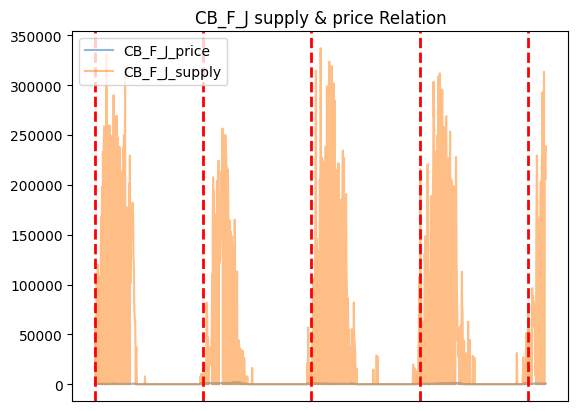

RD


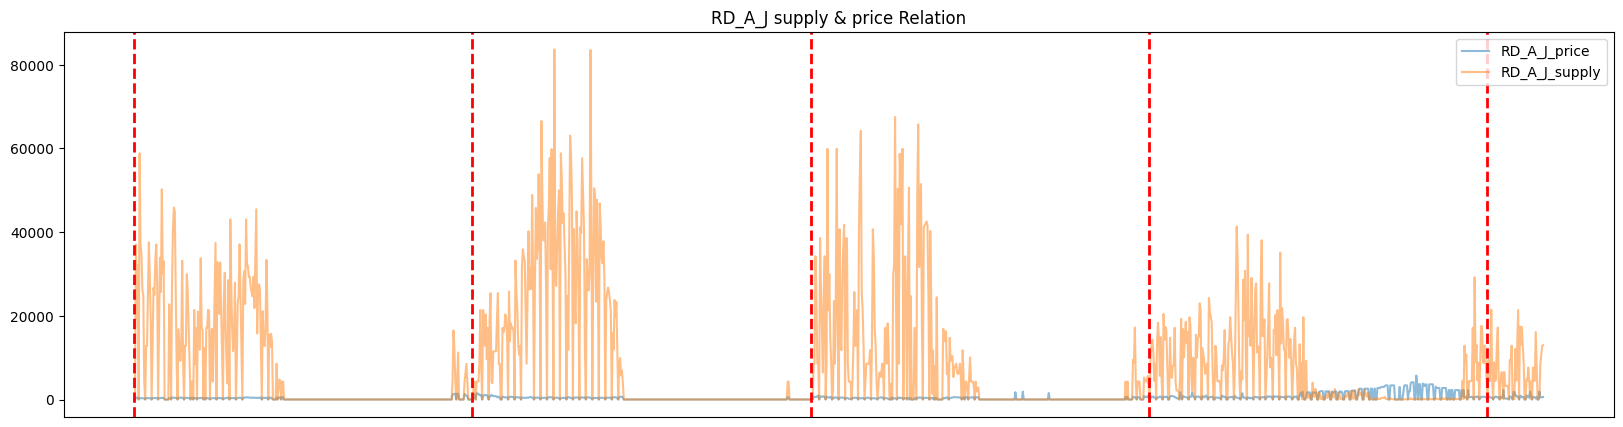

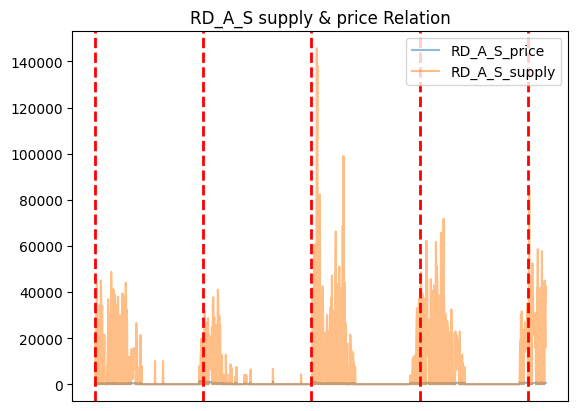

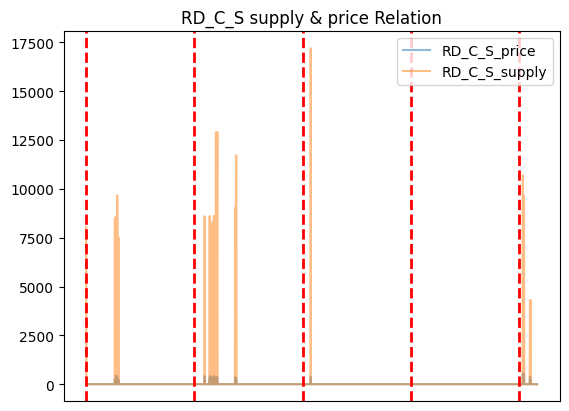

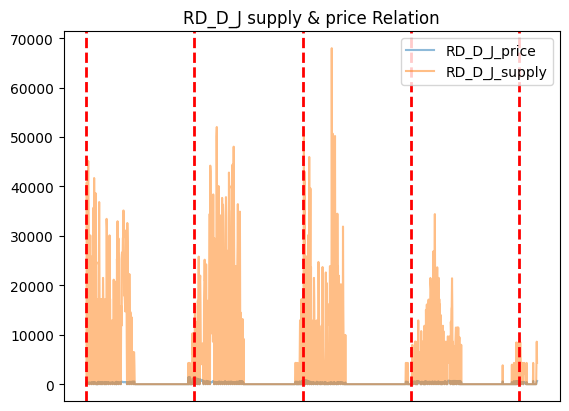

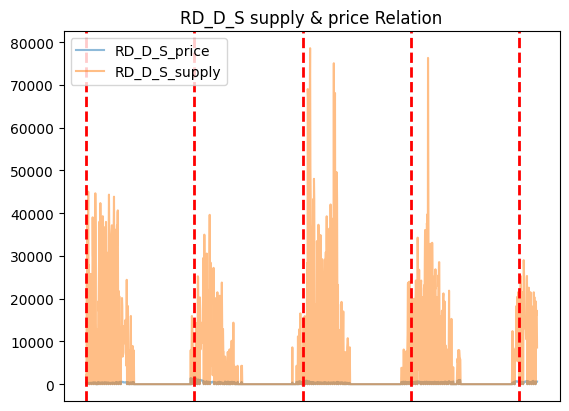

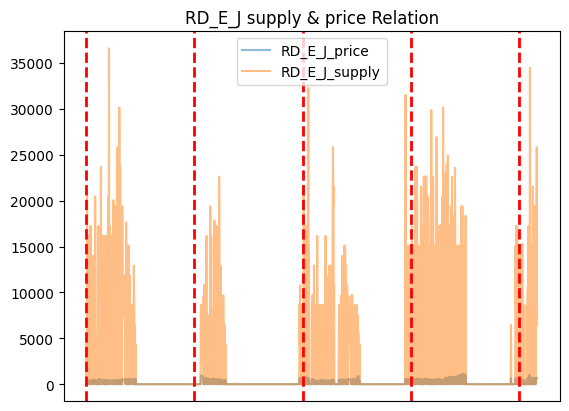

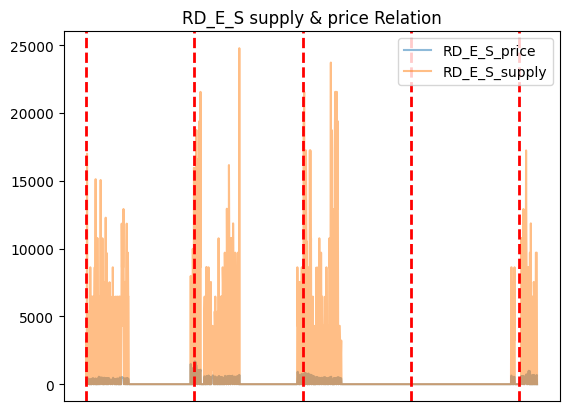

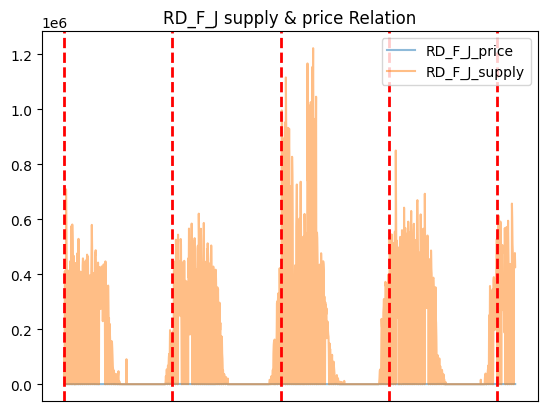

BC


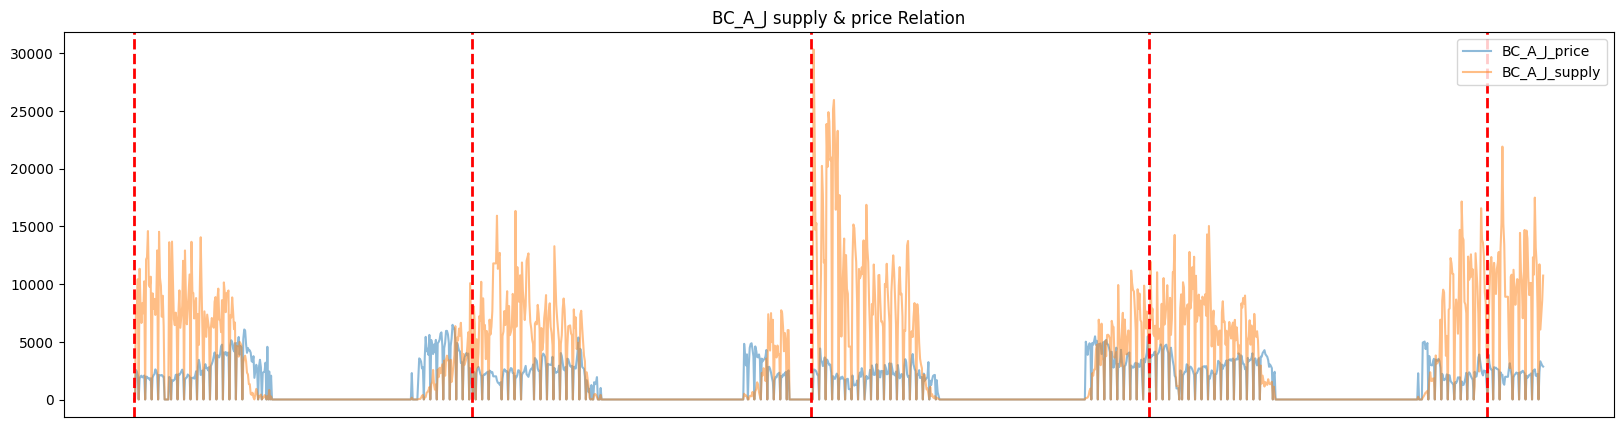

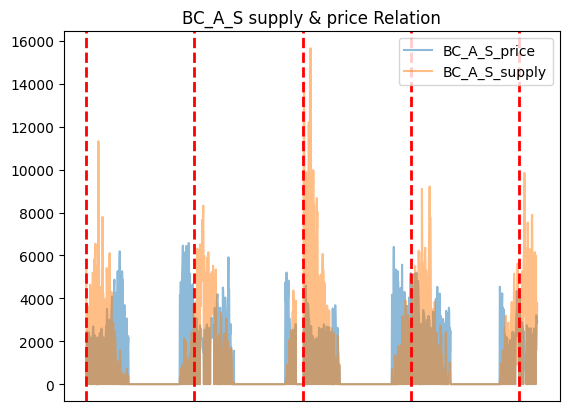

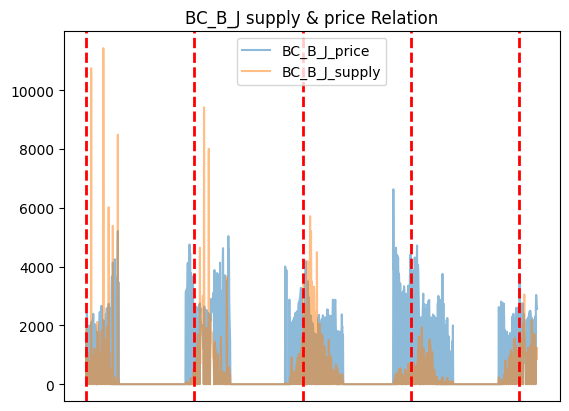

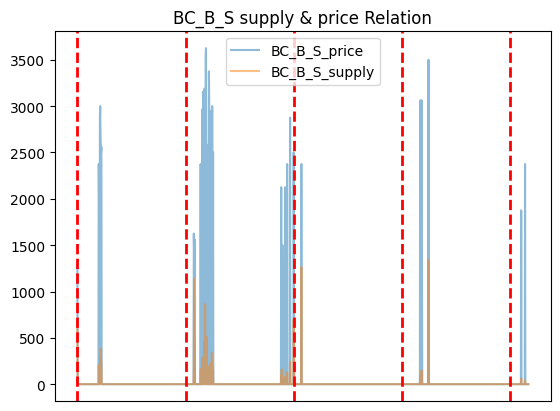

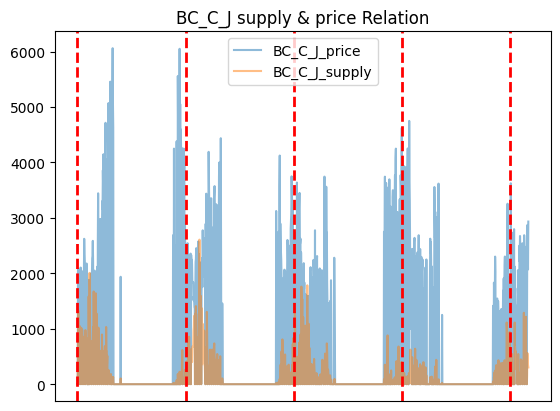

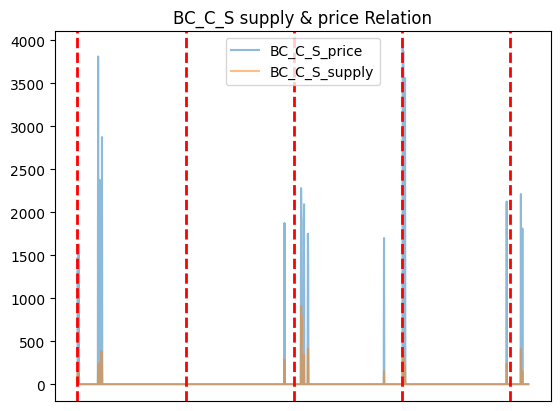

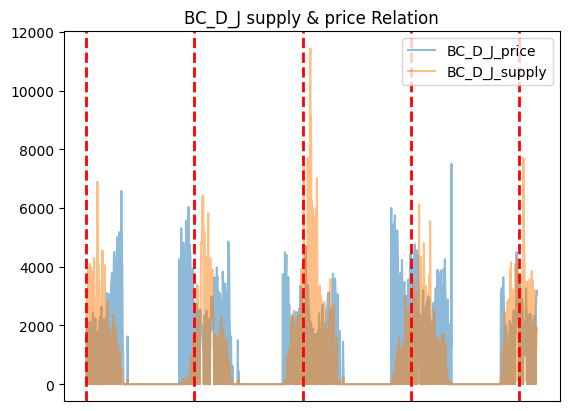

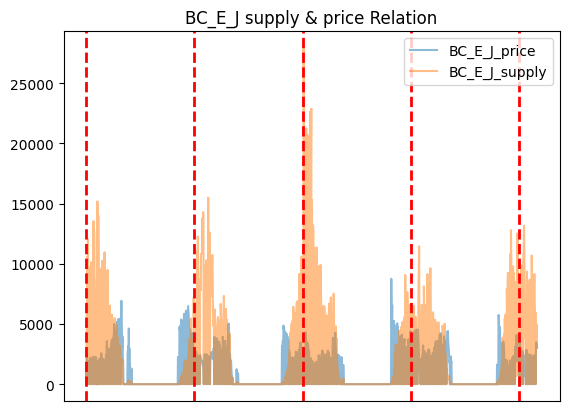

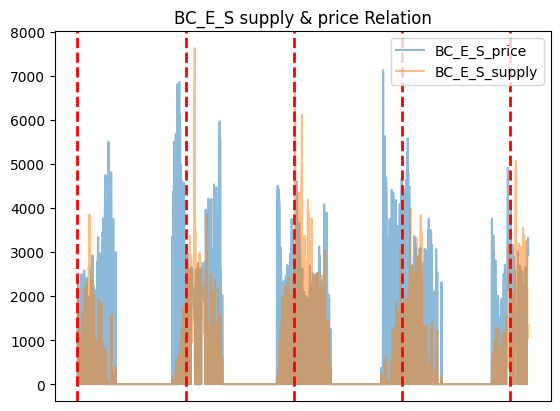

In [ ]:
for idx, item_name in enumerate(list(train.item.unique())):
  print(item_name)
  supply_price_plot(pivot_train, pivot_train_sp, item_name, True)

# 감귤 품목에 경우 대량으로 유통되는 물량 유통 시기와 판매 시기가 다른 것 같습니다.
# 이 점이 공급량을 피처로 포함하여 학습했을때 방해 요인에 해당하는 것 같고
# 외 다른 품목들은 대량으로 물량이 유통되고 곧바로 판매가 됨

# 특이 사항
# CR_A_J, RD_A_J 품목의 경우 특이 케이스인 것을 확인
# 무슨 이유인지 모르겠지만 대량으로 물량 유통이 계속됨을 확인 -> 특이 케이스의 경우에는 최근 N년 동안의 데이터만 가지고 학습하는 것이 더 도움이 될 수 있음

<Axes: xlabel='date'>

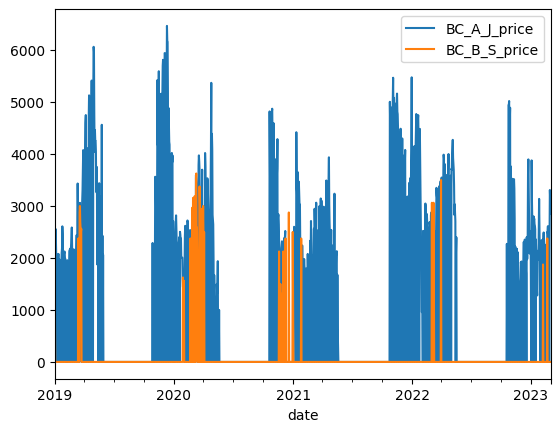

In [ ]:
pivot_train[['BC_A_J_price', 'BC_B_S_price']].plot() # 같은 item, 다른 corporation, 다른 location

<Axes: xlabel='date'>

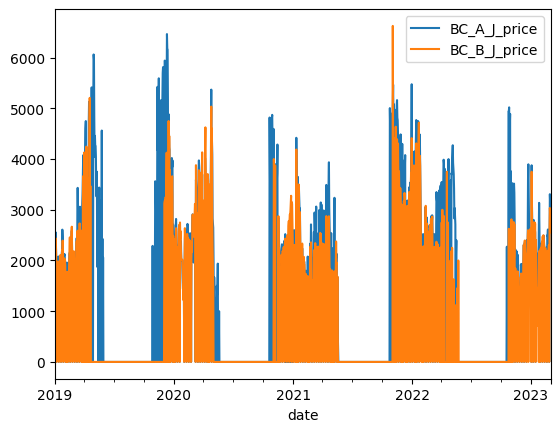

In [ ]:
pivot_train[['BC_A_J_price', 'BC_B_J_price']].plot() # 같은 item, 다른 corporation, 같은 location

<Axes: xlabel='date'>

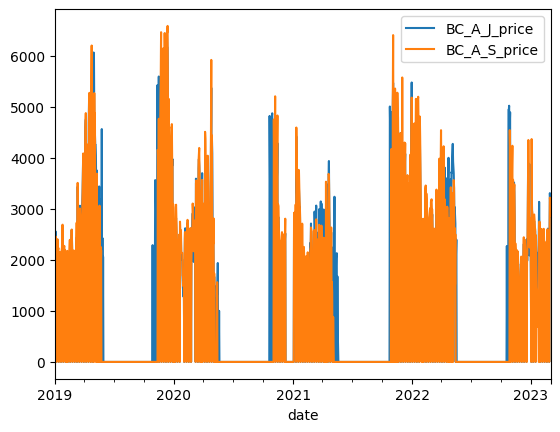

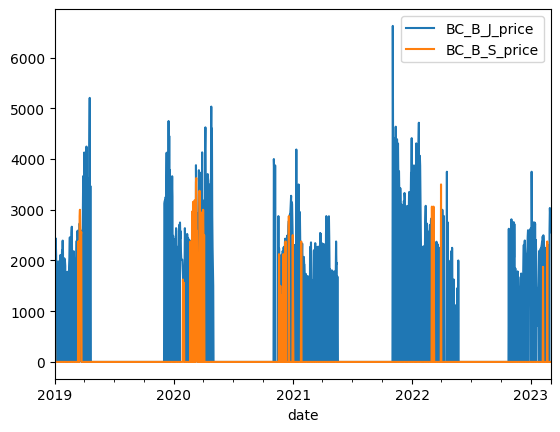

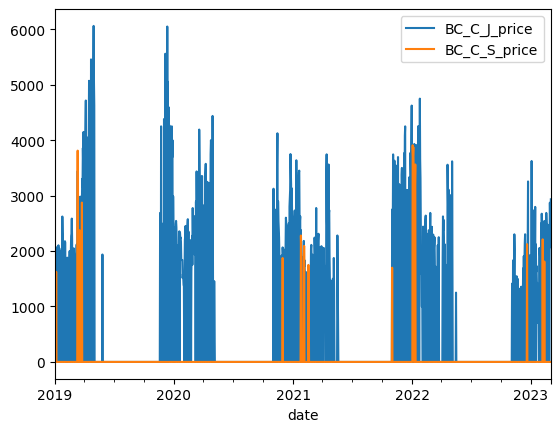

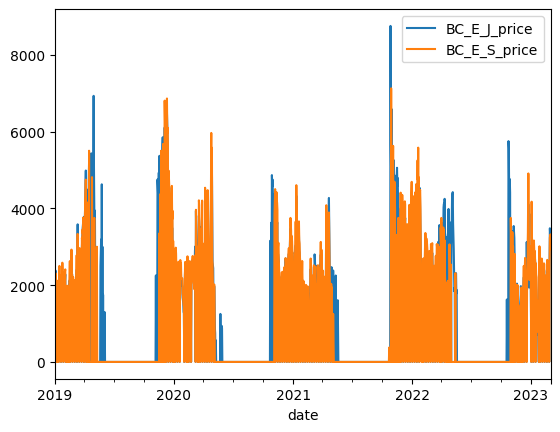

In [ ]:
pivot_train[['BC_A_J_price', 'BC_A_S_price']].plot() # 같은 item, 같은 corporation, 다른 location
pivot_train[['BC_B_J_price', 'BC_B_S_price']].plot()
pivot_train[['BC_C_J_price', 'BC_C_S_price']].plot()
pivot_train[['BC_E_J_price', 'BC_E_S_price']].plot()

같은 품목(item), 같은 회사(corporation), 다른 지역(location)
- 다른 지역일 때 가격의 분포 차이가 비슷한 경우도 존재하지만 전혀 다른 분포 차이의 경우도 존재
location 정보도 중요할 것으로 보임

-> corporation, location을 기준으로 다른 품목별로 나눈 후 모델링 하는 방안도 고려해볼 수 있음

<Axes: >

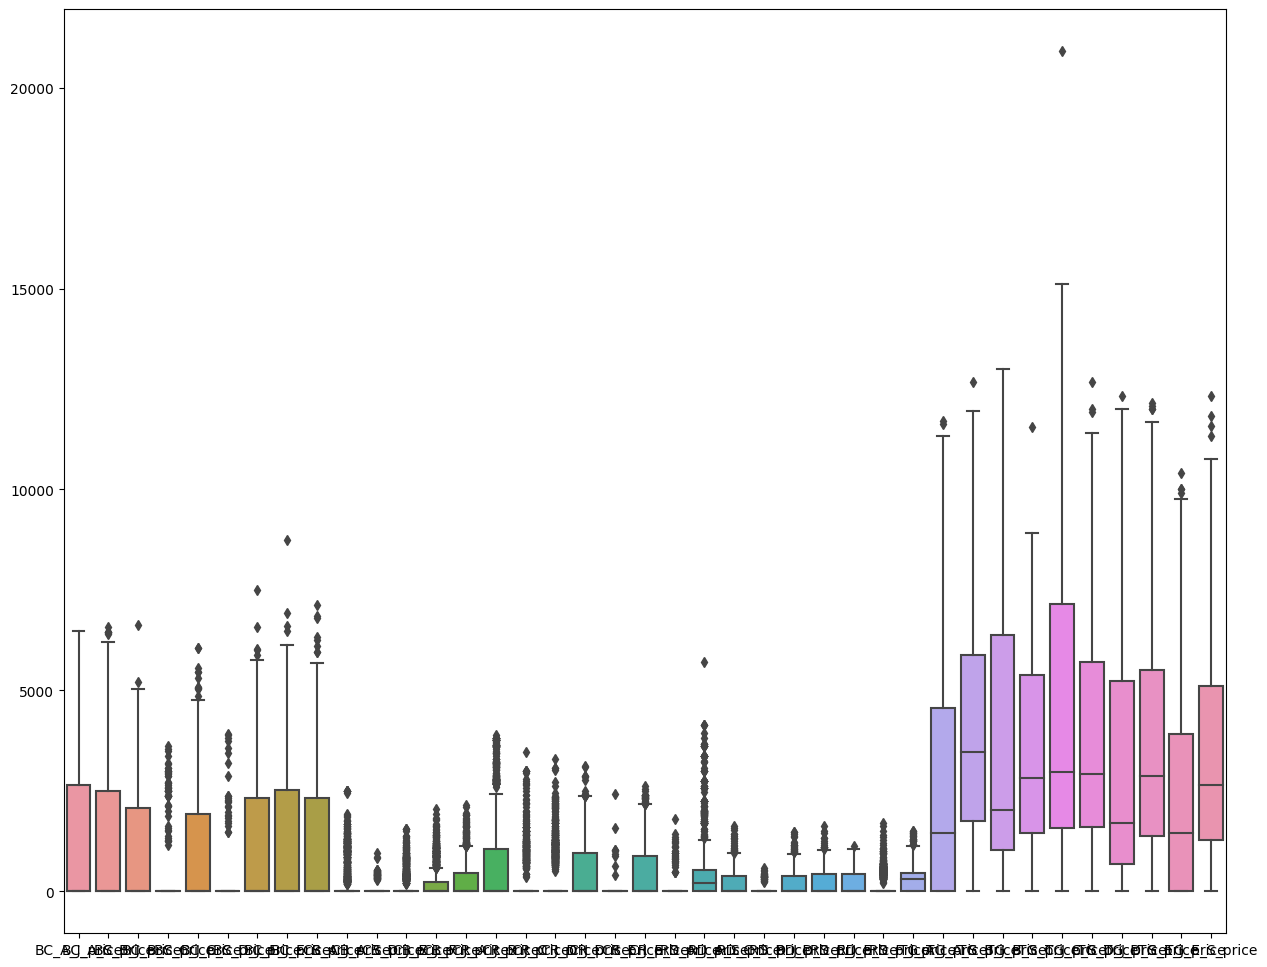

In [ ]:
# 각 품목별로 boxplot

plt.figure(figsize = (15, 12))
sns.boxplot(pivot_train)

외부 요인에 의한 특이치일 가능성이 높음
우리는 테스트 데이터에도 발생할 수 있는 특이치를 정확히 예측하는 것이 중요
- residual 잔차를 피쳐로 사용하는 것이 좋음

품목별, 회사별, 지역별로 다른 trend, seasonal, residual 생성

In [ ]:
# period = 12
# stl = STL(pivot_train[col], period = period)
# res = stl.fit()
# pivot_train[col+'_resid'] = res.resid.values
# pivot_train[col+'_trend'] = res.trend.values
# pivot_train[col+'_seasonal'] = res.seasonal.values

In [ ]:
# # 추가적인 피처 엔지니어링

# # lagging(지연값) -> 전날 가격 혹은 전년도 이날의 가격 같은 정보를 생성 -> 미래의 값을 찾는것이니 전년도 이날의 가격 정보들이 도움이 되지 않을까?
# train['previous_year_price'] = train.price.shift(365)
# train['previous_year_price'] = train['previous_year_price'].fillna(0)

In [ ]:
# 0인 부분들을 어떻게 처리할지?
#0인 부분 특정 값으로 채우고 학습 예측 그리고 후처리로 특정 기준점 이하 값 0 -> 선형보간, 평균보간 혹은 임의로 적당한 낮은 값으로 채움
# 0인 부분이 실제 값인지 대회 주체측에서 임의로 만든 패턴인지 고려

# 임의로 만든 패턴
pivot_train = pivot_train.interpolate(method = 'values') # 선형보간
pivot_train = pivot_train.interpolate(method = 'time') # 시계열 날짜 index를 기준으로 결측값 보간

# 실제값
# 각 품목별 전체 평균값 보간
for column in pivot_train.columns:
  item_mean = pivot_train[column].mean()
  pivot_train[pivot_train[column] == 0] = item_mean

# 각 품목별 선형 평균 보간
for column in pivot_train.columns:
  zero_padding_location = pivot_train[pivot_train[column] == 0].index
  for location in zero_padding_location:
    prev_location = location-1
    next_location = location+1
    while pivot_train.loc[prev_location, column] == 0:
      prev_location += -1
    while pivot_train.loc[next_location, column] == 0:
      next_location += 1
    pivot_train.loc[location, 'price'] = (pivot_train.loc[prev_location, 'price'] + pivot_train.loc[next_location, 'price'])/2
    pivot_train.loc[location, 'supply'] = (pivot_train.loc[prev_location, 'supply'] + pivot_train.loc[next_location, 'supply'])/2

# 임의의 낮은 값
for column in pivot_train.columns:
  pivot_train.loc[pivot_train[column] == 0] = pivot_train[column].min() - pivot_train[column].std()

# 나중에 학습 후 예측 단계에서 threshold(임계치)보다 낮은 값들을 0으로 매핑 -> 좋을 것으로 예상?

In [ ]:
# melted pivot table
pivot_train_ = pivot_train.reset_index()
pivot_train_sp_ = pivot_train_sp.reset_index()

original_train[['item', 'corporation', 'location']] = original_train['combination_column'].str.split('_', expand = True).drop(3,axis=1)
original_train.drop(columns = ['combination_column'], inplace = True)


original_train = pd.melt(pivot_train_, id_vars = 'date', value_vars = pivot_train_.columns[1:], var_name = 'combination_column', value_name = 'price')
original_train_sp = pd.melt(pivot_train_sp_, id_vars = 'date', value_vars = pivot_train_sp_.columns[1:], var_name = 'combination_column', value_name = 'supply')

original_train_sp[['item', 'corporation', 'location']] = original_train_sp['combination_column'].str.split('_', expand = True).drop(3,axis=1)
original_train_sp.drop(columns = ['combination_column'], inplace = True)

In [ ]:
original_train.head()

date        price item corporation location
0 2019-01-01  1418.347341   BC           A        J
1 2019-01-02  1418.347341   BC           A        J
2 2019-01-03  1044.313887   BC           A        J
3 2019-01-04  1044.313887   BC           A        J
4 2019-01-05  1044.313887   BC           A        J

In [ ]:
original_train_sp.head()

date   supply item corporation location
0 2019-01-01      0.0   BC           A        J
1 2019-01-02      0.0   BC           A        J
2 2019-01-03   7616.0   BC           A        J
3 2019-01-04   7488.0   BC           A        J
4 2019-01-05  10408.0   BC           A        J

In [ ]:
# 성능 좋은 모델 앙상블

In [ ]:
## category feature nunique

n_embed1 = train["item"].nunique()
n_embed2 = train["corporation"].nunique()
#n_embed3 = train["location"].nunique()

#n_embed4 = train_date['year'].nunique()
#n_embed5 = train_date['month'].nunique()
#n_embed5 = train_date['year_month'].unique()
#n_embed6 = train_date['day'].nunique()
n_embed7 = train_date['weekday'].nunique()
#n_embed8 = train_date['weekend'].nunique()
# n_embed7 = train_date['friday'].nunique()
#n_embed9 = train_date['season'].nunique()
n_embed8 = train_date['quarter'].nunique()

KeyError: ignored

In [ ]:
train.item.value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [ ]:
# train_tg = train[train.item == 'TG']
# train_bc = train[train.item == 'BC']
# train_rd = train[train.item == 'RD']
# train_cr = train[train.item == 'CR']
# train_cb = train[train.item == 'CB']

In [ ]:
# drop
#train.drop(['location'], axis = 1, inplace = True)
#test.drop(['location'], axis = 1, inplace = True)

In [ ]:
#qual_col = ['item', 'corporation', 'location']
qual_col = ['item', 'corporation', 'location']
date_col = ['weekday']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i])

for i in date_col:
    le = LabelEncoder()
    train_date[i]=le.fit_transform(train_date[i])
    test_date[i]=le.transform(test_date[i])

print('Done.')

Done.


In [ ]:
def Info2Idx(train_info, features):
    info2idx = {}
    for f in features:
        f_unique    = train_info[f].unique()
        info2idx[f] = {k:v+1 for v, k in enumerate(f_unique)}
    return info2idx

info2idx_cat = Info2Idx(train, args.features_cat)
info2idx_date = Info2Idx(train_date, args.features_date)

args.cat_sizes = [len(info2idx_cat[i])+1 for i in args.features_cat]
args.date_sizes = [len(info2idx_date[i])+1 for i in args.features_date]

# wandb.config.update(args)

In [ ]:
args.cat_sizes

[6, 7]

In [ ]:
args.date_sizes

[8]

In [ ]:
# zero except MinmMaxScaling
def scaling(df):
    temp = df[df != 0]
    min_values = temp.min(axis=1)
    max_values = temp.max(axis=1)

    ranges = max_values - min_values
    ranges[ranges == 0] = 1

    scaled_temp = (temp.subtract(min_values, axis=0)).div(ranges, axis=0)

    scale_min_dict = min_values.to_dict()
    scale_max_dict = max_values.to_dict()
    return scaled_temp, scale_min_dict, scale_max_dict

def scaling_inversing(df, scale_min_dict, scale_max_dict):
  temp = df.copy()
  inversed_df = temp * (scale_max_dict - scale_min_dict) + scale_min_dict
  return inversed_df

In [ ]:
train.item.value_counts()

4    15230
0    13707
3    12184
2    10661
1     7615
Name: item, dtype: int64

In [ ]:
# 학습 데이터 생성
train_pv = pd.pivot_table(
    train,
    index = ['item', 'corporation', 'location'],
    columns = ['date'],
    values = ['price']
).reset_index()
train_pv.columns = ["item",	"corporation", 'location'] + [col[1].strftime('%Y-%m-%d') for col in train_pv.columns[3:]]

train_pv.head(3)

item  corporation  location  2019-01-01  2019-01-02  2019-01-03  \
0     0            0         0         0.0         0.0      2559.0   
1     0            0         1      1425.0         0.0      2188.0   
2     0            1         0      1437.5         0.0      2440.0   

   2019-01-04  2019-01-05  2019-01-06  2019-01-07  ...  2023-02-22  \
0      2425.0      2097.0         0.0      1812.0  ...      2611.0   
1      2455.0      2242.0         0.0      1978.0  ...      2378.0   
2      2348.0      2100.0         0.0      1889.0  ...      2160.0   

   2023-02-23  2023-02-24  2023-02-25  2023-02-26  2023-02-27  2023-02-28  \
0      2071.0      2028.0      2222.0         0.0      2357.0      3307.0   
1      2197.0      2060.0      2222.0         0.0      2378.0      3218.0   
2      2014.0      2097.0      2299.0         0.0      2610.0      3035.0   

   2023-03-01  2023-03-02  2023-03-03  
0      3121.5      2936.0      2850.0  
1      3142.5      3067.0      2875.0  
2      2860.0      2685.0      2558.0  

[3 rows x 1526 columns]

In [ ]:
# number 데이터 생성
train_pv_sp = pd.pivot_table(
    train,
    index = ['item', 'corporation', 'location'],
    columns=['date'],
    values=['supply']
).reset_index()
train_pv_sp.columns = ["item",	"corporation", 'location'] + [col[1].strftime('%Y-%m-%d') for col in train_pv_sp.columns[3:]]
train_pv_sp = train_pv_sp.iloc[:, 3:]

train_pv_sp.head(3)

2019-01-01  2019-01-02  2019-01-03  2019-01-04  2019-01-05  2019-01-06  \
0         0.0         0.0      7616.0      7488.0     10408.0         0.0   
1      5364.0         0.0       192.0      1576.0      2608.0         0.0   
2      1888.0         0.0       872.0       648.0      1008.0         0.0   

   2019-01-07  2019-01-08  2019-01-09  2019-01-10  ...  2023-02-22  \
0     11320.0      8064.0      6624.0      8352.0  ...     17480.0   
1      3632.0      2768.0      1840.0      1600.0  ...      5688.0   
2      1032.0       440.0       456.0       448.0  ...      1704.0   

   2023-02-23  2023-02-24  2023-02-25  2023-02-26  2023-02-27  2023-02-28  \
0     13160.0     11736.0      7752.0         0.0     11702.0      6056.0   
1      6160.0      4464.0      2744.0         0.0      5992.0      1576.0   
2      1200.0       744.0       488.0         0.0       968.0      1016.0   

   2023-03-01  2023-03-02  2023-03-03  
0      7328.0      8600.0     10728.0  
1      2208.0      2840.0      3776.0  
2       928.0       840.0      1232.0  

[3 rows x 1523 columns]

In [ ]:
# 파생 피쳐 생성
date_columns = train_pv.columns[3:]

##
exp_avg1 = train_pv.loc[:, date_columns].T.copy()
exp_avg1 = exp_avg1.ewm(alpha=0.99).mean()
exp_avg1 = exp_avg1.T
exp_avg1.fillna(0, inplace=True)

exp_avg2 = train_pv.loc[:, date_columns].T.copy()
exp_avg2 = exp_avg2.ewm(alpha=1/180, min_periods=180).mean()
exp_avg2 = exp_avg2.T
exp_avg2.fillna(0, inplace=True)

previous_price = train_pv.loc[:, date_columns].T.copy()
previous_year_price = previous_price.shift(356)
previous_year_price = previous_year_price.T
previous_year_price.fillna(0, inplace = True)

previous_supply = train_pv_sp.loc[:, date_columns].T.copy()
previous_year_supply  = previous_supply.shift(356)
previous_year_supply  = previous_year_supply.T
previous_year_supply.fillna(0, inplace = True)

# mov_avg_31 = train_pv.loc[:, date_columns].T.copy()
# mov_avg_31 = mov_avg_31.rolling(window=31).mean()
# mov_avg_31 = mov_avg_31.T
# mov_avg_31.fillna(0, inplace=True)

# mov_avg_90 = train_pv.loc[:, date_columns].T.copy()
# mov_avg_90 = mov_avg_90.rolling(window=90).mean()
# mov_avg_90 = mov_avg_90.T
# mov_avg_90.fillna(0, inplace=True)

# exp_mov_avg_31 = train_pv.loc[:, date_columns].T.copy()
# exp_mov_avg_31 = exp_mov_avg_31.ewm(span=31, adjust=False).mean()
# exp_mov_avg_31 = exp_mov_avg_31.T
# exp_mov_avg_31.fillna(0, inplace=True)

# mov_rate = train_pv.loc[:, date_columns].T.copy()
# mov_rate_max = mov_rate.rolling(window=14).max()
# mov_rate_min = mov_rate.rolling(window=14).min()
# mov_rate = (mov_rate_max - mov_rate_min).T
# mov_rate.fillna(0, inplace=True)

# mov_avg_31, _, _ = scaling(exp_avg1)
# mov_avg_90, _, _ = scaling(exp_avg2)
# previous_year_price, _, _ = scaling(previous_year_price)

In [ ]:
# 예측한 값을 해당 테이블에 값을 채움
test_sub = test.copy()
test_sub['price'] = 0

test_pv = pd.pivot_table(
    test_sub,
    index = ['item', 'corporation', 'location'],
    columns=['date'],
    values=['price']
).reset_index()
test_pv.columns = ["item",	"corporation", 'location'] + [col[1].strftime('%Y-%m-%d') for col in test_pv.columns[3:]]

test_pv.head(3)

item  corporation  location  2023-03-04  2023-03-05  2023-03-06  \
0     0            0         0           0           0           0   
1     0            0         1           0           0           0   
2     0            1         0           0           0           0   

   2023-03-07  2023-03-08  2023-03-09  2023-03-10  ...  2023-03-22  \
0           0           0           0           0  ...           0   
1           0           0           0           0  ...           0   
2           0           0           0           0  ...           0   

   2023-03-23  2023-03-24  2023-03-25  2023-03-26  2023-03-27  2023-03-28  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   2023-03-29  2023-03-30  2023-03-31  
0           0           0           0  
1           0           0           0  
2           0           0           0  

[3 rows x 31 columns]

In [ ]:
# test 데이터의 index를 저장
test_id = pd.pivot_table(
    test_sub,
    index = ['item', 'corporation', 'location'],
    columns=['date'],
    values=['ID'],
    aggfunc='first'
).reset_index()
test_id.columns = ["item",	"corporation", 'location'] + [col[1].strftime('%Y-%m-%d') for col in test_id.columns[3:]]

test_id.head()

item  corporation  location       2023-03-04       2023-03-05  \
0     0            0         0  BC_A_J_20230304  BC_A_J_20230305   
1     0            0         1  BC_A_S_20230304  BC_A_S_20230305   
2     0            1         0  BC_B_J_20230304  BC_B_J_20230305   
3     0            1         1  BC_B_S_20230304  BC_B_S_20230305   
4     0            2         0  BC_C_J_20230304  BC_C_J_20230305   

        2023-03-06       2023-03-07       2023-03-08       2023-03-09  \
0  BC_A_J_20230306  BC_A_J_20230307  BC_A_J_20230308  BC_A_J_20230309   
1  BC_A_S_20230306  BC_A_S_20230307  BC_A_S_20230308  BC_A_S_20230309   
2  BC_B_J_20230306  BC_B_J_20230307  BC_B_J_20230308  BC_B_J_20230309   
3  BC_B_S_20230306  BC_B_S_20230307  BC_B_S_20230308  BC_B_S_20230309   
4  BC_C_J_20230306  BC_C_J_20230307  BC_C_J_20230308  BC_C_J_20230309   

        2023-03-10  ...       2023-03-22       2023-03-23       2023-03-24  \
0  BC_A_J_20230310  ...  BC_A_J_20230322  BC_A_J_20230323  BC_A_J_20230324   
1  BC_A_S_20230310  ...  BC_A_S_20230322  BC_A_S_20230323  BC_A_S_20230324   
2  BC_B_J_20230310  ...  BC_B_J_20230322  BC_B_J_20230323  BC_B_J_20230324   
3  BC_B_S_20230310  ...  BC_B_S_20230322  BC_B_S_20230323  BC_B_S_20230324   
4  BC_C_J_20230310  ...  BC_C_J_20230322  BC_C_J_20230323  BC_C_J_20230324   

        2023-03-25       2023-03-26       2023-03-27       2023-03-28  \
0  BC_A_J_20230325  BC_A_J_20230326  BC_A_J_20230327  BC_A_J_20230328   
1  BC_A_S_20230325  BC_A_S_20230326  BC_A_S_20230327  BC_A_S_20230328   
2  BC_B_J_20230325  BC_B_J_20230326  BC_B_J_20230327  BC_B_J_20230328   
3  BC_B_S_20230325  BC_B_S_20230326  BC_B_S_20230327  BC_B_S_20230328   
4  BC_C_J_20230325  BC_C_J_20230326  BC_C_J_20230327  BC_C_J_20230328   

        2023-03-29       2023-03-30       2023-03-31  
0  BC_A_J_20230329  BC_A_J_20230330  BC_A_J_20230331  
1  BC_A_S_20230329  BC_A_S_20230330  BC_A_S_20230331  
2  BC_B_J_20230329  BC_B_J_20230330  BC_B_J_20230331  
3  BC_B_S_20230329  BC_B_S_20230330  BC_B_S_20230331  
4  BC_C_J_20230329  BC_C_J_20230330  BC_C_J_20230331  

[5 rows x 31 columns]

In [ ]:
def make_data_modified(
    data, info, date, num_info, num_shape,
    window_size=WINDOW_SIZE,
    predict_size=PREDICT_SIZE,
    step_size=SLIDING_SIZE,
    validation_size=VALIDATION_SIZE
):

    samples, time    = data.shape
    _, features      = info.shape
    _, feature_dates = date.shape
    if len(args.features_num) > 1:
        # 여러 Number 변수를 할당
        num_ex1 = num_info[:num_shape[0], :]
        num_ex2 = num_info[num_shape[0]:num_shape[0] + num_shape[1], :]
        # num_sp = num_info[num_shape[0] + num_shape[1]:, :]

    split_time = round(time * (1 - validation_size))

    ## train_dataset

    num_windows = floor((split_time - window_size - predict_size + 1) / step_size)

    train_input_data = np.empty((samples * num_windows, window_size, 1))
    train_input_info = np.empty((samples * num_windows, features))
    train_input_date = np.empty((samples * num_windows, window_size, feature_dates))
    train_input_num_info = np.empty((samples * num_windows, window_size, len(args.features_num)))
    train_output_data = np.empty((samples * num_windows, predict_size))

    for i, s in enumerate(tqdm(range(samples))):
        for w in range(num_windows):
            actual_step = floor(w * step_size)  # 실수 step_size를 곱한 후 내림을 적용하여 정수로 만듭니다.
            idx = (s * num_windows) + w
            train_input_data[idx, :, 0] = data[s, actual_step:actual_step+window_size]
            train_input_info[idx, :] = info[s, :]
            train_input_date[idx, :, :] = date[actual_step:actual_step+window_size, :]

            if len(args.features_num) > 1:
                train_input_num_info[idx, :, 0] = num_ex1[s, actual_step:actual_step+window_size]
                train_input_num_info[idx, :, 1] = num_ex2[s, actual_step:actual_step+window_size]
                # train_input_num_info[idx, :, 2] = num_sp[s, actual_step:actual_step+window_size]
            else:
                train_input_num_info[idx, :, 0] = num_info[s, actual_step:actual_step+window_size]

            train_output_data[idx, :] = data[s, actual_step+window_size:actual_step+window_size+predict_size]

    ## val_dataset

    num_windows = time - split_time - window_size - predict_size + 1

    val_input_data = np.empty((samples * num_windows, window_size, 1))
    val_input_info = np.empty((samples * num_windows, features))
    val_input_date = np.empty((samples * num_windows, window_size, feature_dates))
    val_input_num_info = np.empty((samples * num_windows, window_size, len(args.features_num)))
    val_output_data = np.empty((samples * num_windows, predict_size))

    for s in tqdm(range(samples)):
        for w in range(num_windows):
            val_input_data[s * num_windows + w, :, 0] = data[s, split_time + w : split_time + w + window_size]
            val_input_info[s * num_windows + w, :] = info[s, :]
            val_input_date[s * num_windows + w, :, :] = date[split_time + w : split_time + w + window_size, :]

            if len(args.features_num) > 1:
                val_input_num_info[s * num_windows + w, :, 0] = num_ex1[s, split_time + w : split_time + w + window_size]
                val_input_num_info[s * num_windows + w, :, 1] = num_ex2[s, split_time + w : split_time + w + window_size]
                # val_input_num_info[s * num_windows + w, :, 2] = num_sp[s, split_time + w : split_time + w + window_size]
            else:
                val_input_num_info[s * num_windows + w, :, 0] = num_info[s, split_time + w : split_time + w + window_size]

            val_output_data[s * num_windows + w, :] = data[s, split_time + w + window_size : split_time + w + window_size + predict_size]

    ## final_train_dataset

    num_windows = floor((time - window_size - predict_size + 1) / step_size)

    fin_train_input_data = np.empty((samples * num_windows, window_size, 1))
    fin_train_input_info = np.empty((samples * num_windows, features))
    fin_train_input_date = np.empty((samples * num_windows, window_size, feature_dates))
    fin_train_input_num_info = np.empty((samples * num_windows, window_size, len(args.features_num)))
    fin_train_output_data = np.empty((samples * num_windows, predict_size))

    for s in tqdm(range(samples)):
        for w in range(num_windows):
            actual_step = floor(w * step_size)  # 실수 step_size를 곱한 후 내림을 적용하여 정수로 만듭니다.
            idx = (s * num_windows) + w
            fin_train_input_data[idx, :, 0] = data[s, actual_step:actual_step+window_size]
            fin_train_input_info[idx, :] = info[s, :]
            fin_train_input_date[idx, :, :] = date[actual_step:actual_step+window_size, :]

            if len(args.features_num) > 1:
                fin_train_input_num_info[idx, :, 0] = num_ex1[s, actual_step:actual_step+window_size]
                fin_train_input_num_info[idx, :, 1] = num_ex2[s, actual_step:actual_step+window_size]
                # fin_train_input_num_info[idx, :, 2] = num_sp[s, actual_step:actual_step+window_size]
            else:
                fin_train_input_num_info[idx, :, 0] = num_info[s, actual_step:actual_step+window_size]

            fin_train_output_data[idx, :] = data[s, actual_step+window_size:actual_step+window_size+predict_size]

    ## test_dataset

    test_input_data = np.empty((samples, window_size, 1))
    test_input_info = np.empty((samples, features))
    test_input_date = np.empty((samples, window_size, feature_dates))
    test_input_num_info = np.empty((samples, window_size, len(args.features_num)))

    for s in tqdm(range(samples)):
        test_input_data[s, :, 0] = data[s, -window_size:]
        test_input_info[s, :] = info[s, :]
        test_input_date[s, :, :] = date[-window_size:, :]
        if len(args.features_num) > 1:
            test_input_num_info[s, :, 0] = num_ex1[s, -window_size:]
            test_input_num_info[s, :, 1] = num_ex2[s, -window_size:]
            # test_input_num_info[s, :, 2] = num_sp[s, -window_size:]
        else:
            test_input_num_info[s, :, 0] = num_info[s, -window_size:]

    return {
        "train_dataset" : [train_input_data, train_input_info,
                            train_input_date, train_input_num_info, train_output_data],

        "val_dataset" : [val_input_data, val_input_info,
                            val_input_date, val_input_num_info, val_output_data],

        "fin_train_dataset" : [fin_train_input_data, fin_train_input_info,
                                fin_train_input_date, fin_train_input_num_info, fin_train_output_data],

        "test_dataset" : [test_input_data, test_input_info,
                            test_input_date, test_input_num_info],
    }

In [ ]:
info_len = len(args.features_cat)
date_len = len(args.features_date)

data = train_pv.iloc[:, info_len:].values
info = train_pv.iloc[:, :info_len].values
date = train_date.values

select_num_feat = [exp_avg1, exp_avg2, previous_year_price, train_pv_sp, previous_year_supply]
num_shape = [feat.shape[0] for feat in select_num_feat]

if len(args.features_num) > 1:
    num_info = pd.concat(select_num_feat, axis=0) # exp_avg1, exp_avg2, mov_avg_90, exp_mov_avg_31
    num_info = num_info.values
else:
    num_info = exp_avg1.values                    # 해당 변수는 좋은 변수였음으로 고정

data.shape, info.shape, date.shape, num_info.shape

((39, 1524), (39, 2), (1523, 1), (195, 1523))

In [ ]:
dataset = make_data_modified(data, info, date, num_info, num_shape)

100%|██████████| 39/39 [00:00<00:00, 79406.73it/s]


In [ ]:
train_input, train_info_cat, train_info_date, train_info_num, train_target = dataset["train_dataset"]
val_input, val_info_cat, val_info_date, val_info_num, val_target = dataset["val_dataset"]
fin_train_input, fin_train_info_cat, fin_train_info_date, fin_train_info_num, fin_train_target = dataset["fin_train_dataset"]
test_input, test_info_cat, test_info_date, test_info_num = dataset["test_dataset"]

print("="*4,"train data","="*4)
print(train_input.shape)
print(train_info_cat.shape)
print(train_info_date.shape)
print(train_info_num.shape)
print(train_target.shape)

print("="*4,"val data","="*4)
print(val_input.shape)
print(val_info_cat.shape)
print(val_info_date.shape)
print(val_info_num.shape)
print(val_target.shape)

print("="*4,"final data","="*4)
print(fin_train_input.shape)
print(fin_train_info_cat.shape)
print(fin_train_info_date.shape)
print(fin_train_info_num.shape)
print(fin_train_target.shape)

print("="*4,"test data","="*4)
print(test_input.shape)
print(test_info_cat.shape)
print(test_info_date.shape)
print(test_info_num.shape)

==== train data ====
(39468, 180, 1)
(39468, 2)
(39468, 180, 1)
(39468, 180, 5)
(39468, 28)
==== val data ====
(3822, 180, 1)
(3822, 2)
(3822, 180, 1)
(3822, 180, 5)
(3822, 28)
==== final data ====
(51363, 180, 1)
(51363, 2)
(51363, 180, 1)
(51363, 180, 5)
(51363, 28)
==== test data ====
(39, 180, 1)
(39, 2)
(39, 180, 1)
(39, 180, 5)


## data_loader.py

In [ ]:
class SalesDataset(Dataset):
    def __init__(self, X, INFO_CAT, INFO_DATE, INFO_NUM, Y):
        self.X = X
        self.INFO_CAT = INFO_CAT
        self.INFO_DATE = INFO_DATE
        self.INFO_NUM = INFO_NUM
        self.Y = Y

    def __getitem__(self, index):
        data = {
            "X": torch.Tensor(self.X[index]),
        }

        if self.INFO_CAT is not None:
            data["INFO_CAT"] = torch.LongTensor(self.INFO_CAT[index])

        if self.INFO_DATE is not None:
            data["INFO_DATE"] = torch.LongTensor(self.INFO_DATE[index])

        if self.Y is not None:
            data["Y"] = torch.Tensor(self.Y[index])

        if self.INFO_NUM is not None:
            data["INFO_NUM"] = torch.Tensor(self.INFO_NUM[index])

        return data

    def __len__(self):
        return len(self.X)

## models.py

In [ ]:
## feature embedding module

class SequenceEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, window_size, dropout=0.1):
        super(SequenceEmbedding, self).__init__()

        self.rnn_emb = getattr(nn, 'GRU')(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.linear  = nn.Sequential(
            nn.Linear(hidden_size*2, window_size),
            nn.LayerNorm(window_size),
            nn.ReLU()
            )

    def forward(self, x):

        x, _ = self.rnn_emb(self.dropout(x))
        x    = self.linear(x)

        return x

class CatFeatureEmbedding(nn.Module):
    def __init__(self, f_sizes, hidden_size, window_size, dropout):
        super().__init__()

        self.feat_num = len(f_sizes)
        self.feat_emb = nn.ModuleList([nn.Embedding(i, hidden_size) for i in f_sizes])
        self.linear   = nn.Sequential(
            nn.Linear(hidden_size*self.feat_num, window_size),
            nn.BatchNorm1d(window_size),
            nn.ReLU()
            )

    def forward(self, features):

        outputs = []
        for i in range(self.feat_num):
            outputs.append(self.feat_emb[i](features[:, i]))
        outputs = torch.hstack(outputs)
        outputs = self.linear(outputs)

        return outputs

class DateFeatureEmbedding(nn.Module):
    def __init__(self, f_sizes, hidden_size, window_size, dropout):
        super().__init__()

        self.feat_num = len(f_sizes)
        self.feat_emb = nn.ModuleList([nn.Embedding(i, hidden_size) for i in f_sizes])
        self.linear   = nn.Sequential(
            nn.Linear(hidden_size*self.feat_num, window_size),
            nn.BatchNorm1d(window_size),
            nn.ReLU()
            )

    def forward(self, features):
        outputs = []
        for i in range(self.feat_num):
            outputs.append(self.feat_emb[i](features[:, :, i]))
        outputs = torch.cat(outputs, dim=2)
        outputs = self.linear(outputs)
        outputs = outputs.mean(dim=2)
        return outputs

In [ ]:
## DLinear - decomposition module

class Moving_Avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(Moving_Avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)

        return x

class Series_Decompsition(nn.Module):
    def __init__(self, kernel_size):
        super(Series_Decompsition, self).__init__()
        self.moving_avg = Moving_Avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean

        return moving_mean, residual

In [ ]:
class STSF_Linear(nn.Module):
    def __init__(self, args):
        super(STSF_Linear, self).__init__()

        self.embed_type   = args.embed_type
        self.window_size  = args.window_size
        self.predict_size = args.predict_size

        self.norm    = nn.LayerNorm(self.window_size)
        self.hidden1 = nn.Sequential(
            nn.Linear(1, self.window_size // 2),
            nn.ReLU())
        self.hidden2 = nn.Sequential(
            nn.Linear(len(args.features_num), self.window_size // 2),
            nn.ReLU())
        self.hidden3 = nn.Sequential(
            nn.Linear(self.window_size, 1),
            nn.ReLU())
        self.Linear  = nn.Linear(self.window_size, self.predict_size)

    def forward(self, x, features_cat, features_date, features_num):

        if self.embed_type == "sequence":
            x = x.mean(dim=1).unsqueeze(2)

        if (features_cat is None) & (features_date is None) & (features_num is None):
            x = x

        elif (features_cat is not None) & (features_date is None) & (features_num is None):
            x = x + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is not None) & (features_num is None):
            x = x + features_date
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is None) & (features_num is not None):
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        elif (features_cat is not None) & (features_date is not None) & (features_num is None):
            x = x + features_date + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is not None) & (features_num is not None):
            x = x + features_date
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        elif (features_cat is not None) & (features_date is None) & (features_num is not None):
            x = x + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        else:
            x = x + features_date + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        x = F.relu(self.Linear(x.permute(0, 2, 1)).permute(0, 2, 1))

        return x.squeeze()

In [ ]:
class STSF_DLinear(nn.Module):
    def __init__(self, args):
        super(STSF_DLinear, self).__init__()

        self.embed_type   = args.embed_type
        self.window_size  = args.window_size
        self.predict_size = args.predict_size
        self.kernel_size  = args.kernel_size

        self.norm    = nn.LayerNorm(self.window_size)
        self.hidden1 = nn.Sequential(
            nn.Linear(1, self.window_size // 2),
            nn.ReLU())
        self.hidden2 = nn.Sequential(
            nn.Linear(len(args.features_num), self.window_size // 2),
            nn.ReLU())
        self.hidden3 = nn.Sequential(
            nn.Linear(self.window_size, 1),
            nn.ReLU())

        self.decompsition = Series_Decompsition(self.kernel_size)
        self.Linear_Trend = nn.Linear(self.window_size, self.predict_size)
        self.Linear_Trend.weight = nn.Parameter((1/self.window_size)*
                                                torch.ones(self.predict_size, self.window_size))

        self.Linear_Seasonal = nn.Linear(self.window_size, self.predict_size)
        self.Linear_Seasonal.weight = nn.Parameter((1/self.window_size)*
                                                    torch.ones(self.predict_size, self.window_size))

    def forward(self, x, features_cat, features_date, features_num):

        if self.embed_type == "sequence":
            x = x.mean(dim=1).unsqueeze(2)

        if (features_cat is None) & (features_date is None) & (features_num is None):
            x = x

        elif (features_cat is not None) & (features_date is None) & (features_num is None):
            x = x + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is not None) & (features_num is None):
            x = x + features_date
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is None) & (features_num is not None):
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        elif (features_cat is not None) & (features_date is not None) & (features_num is None):
            x = x + features_date + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is not None) & (features_num is not None):
            x = x + features_date
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        elif (features_cat is not None) & (features_date is None) & (features_num is not None):
            x = x + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        else:
            x = x + features_date + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        trend_init, seosonal_init = self.decompsition(x)
        trend_init, seosonal_init = trend_init.permute(0, 2, 1), seosonal_init.permute(0, 2, 1)

        trend_output = self.Linear_Trend(trend_init)
        seosonal_output = self.Linear_Seasonal(seosonal_init)

        x = trend_output + seosonal_output
        x = F.relu(x)

        return x.permute(0, 2, 1).squeeze()

In [ ]:
class STSF_NLinear(nn.Module):
    def __init__(self, args):
        super(STSF_NLinear, self).__init__()

        self.embed_type   = args.embed_type
        self.window_size  = args.window_size
        self.predict_size = args.predict_size

        self.norm    = nn.LayerNorm(self.window_size)
        self.hidden1 = nn.Sequential(
            nn.Linear(1, self.window_size // 2),
            nn.ReLU())
        self.hidden2 = nn.Sequential(
            nn.Linear(len(args.features_num), self.window_size // 2),
            nn.ReLU())
        self.hidden3 = nn.Sequential(
            nn.Linear(self.window_size, 1),
            nn.ReLU())
        self.Lienar  = nn.Linear(self.window_size, self.predict_size)

    def forward(self, x, features_cat, features_date, features_num):

        if self.embed_type == "sequence":
            x = x.mean(dim=1).unsqueeze(2)

        if (features_cat is None) & (features_date is None) & (features_num is None):
            x = x

        elif (features_cat is not None) & (features_date is None) & (features_num is None):
            x = x + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is not None) & (features_num is None):
            x = x + features_date
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is None) & (features_num is not None):
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        elif (features_cat is not None) & (features_date is not None) & (features_num is None):
            x = x + features_date + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        elif (features_cat is None) & (features_date is not None) & (features_num is not None):
            x = x + features_date
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        elif (features_cat is not None) & (features_date is None) & (features_num is not None):
            x = x + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        else:
            x = x + features_date + features_cat
            x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = self.hidden1(x)
            x_num = self.hidden2(features_num)
            x = torch.cat((x, x_num), dim=-1)
            x = self.hidden3(x)

        seq_last = x[:, -1:, :]
        x = x - seq_last
        x = self.Lienar(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = x + seq_last

        return x.squeeze(2)

In [ ]:
class STSF_Model(nn.Module):
    def __init__(self, args):
        super(STSF_Model, self).__init__()

        self.c_in = 1
        self.use_feat_cat = args.use_feat_cat
        self.use_feat_date = args.use_feat_date

        # model selection
        if args.forcast_model == 'Linear':
            self.model = STSF_Linear(args)
        if args.forcast_model == 'DLinear':
            self.model = STSF_DLinear(args)
        if args.forcast_model == 'NLinear':
            self.model = STSF_NLinear(args)

        # feature embedding
        if args.use_feat_cat:
            self.feat_emb_cat = CatFeatureEmbedding(args.cat_sizes, args.hidden_size, args.window_size, args.dropout) # feature embedding
        if args.use_feat_date:
            self.feat_emb_date = DateFeatureEmbedding(args.date_sizes, args.hidden_size, args.window_size, args.dropout) # feature embedding
        if args.embed_type=="sequence":
            self.enc_emb = SequenceEmbedding(self.c_in, args.hidden_size, args.window_size, args.dropout)

    def forward(self, x, features_cat=None, features_date=None, features_num=None):

        if args.embed_type=="sequence":
            x = self.enc_emb(x)

        if self.use_feat_cat:
            features_cat = self.feat_emb_cat(features_cat) # (B, num features) -> (B, C)
            features_cat = features_cat.unsqueeze(2)

        if self.use_feat_date:
            features_date = self.feat_emb_date(features_date)
            features_date = features_date.unsqueeze(2)

        output = self.model(x, features_cat, features_date, features_num)

        return output

In [ ]:
class STSF_Classifier(pl.LightningModule):
    def __init__(self, backbone, args):
        super().__init__()
        self.backbone = backbone

    def forward(self, x, info_cat, info_num):
        return self.backbone(x, info_cat, info_num)

    def step(self, batch):
        x = batch["X"]

        if (args.use_feat_cat) & (args.use_feat_date) &(args.use_feat_num):
            info_cat  = batch["INFO_CAT"]
            info_date = batch["INFO_DATE"]
            info_num  = batch["INFO_NUM"]
        elif (args.use_feat_cat) & (args.use_feat_date):
            info_cat  = batch["INFO_CAT"]
            info_date = batch["INFO_DATE"]
            info_num  = None
        elif (args.use_feat_cat) & (args.use_feat_num):
            info_cat  = batch["INFO_CAT"]
            info_date = None
            info_num  = batch["INFO_NUM"]
        elif (args.use_feat_date) & (args.use_feat_num):
            info_cat  = None
            info_date = batch["INFO_DATE"]
            info_num  = batch["INFO_NUM"]
        elif args.use_feat_cat:
            info_cat  = batch["INFO_CAT"]
            info_date = None
            info_num  = None
        elif args.use_feat_date:
            info_cat  = None
            info_date = batch["INFO_DATE"]
            info_num  = None
        elif args.use_feat_num:
            info_cat  = None
            info_date = None
            info_num  = batch["INFO_NUM"]
        else:
            info_cat  = None
            info_date = None
            info_num  = None

        y = batch["Y"]
        y_hat = self.backbone(x, info_cat, info_date, info_num)
        loss  = torch.sqrt(nn.MSELoss()(y_hat, y))
        return loss, y, y_hat

    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        self.log("test_loss", loss)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch["X"]

        if (args.use_feat_cat) & (args.use_feat_date) &(args.use_feat_num):
            info_cat  = batch["INFO_CAT"]
            info_date = batch["INFO_DATE"]
            info_num  = batch["INFO_NUM"]
        elif (args.use_feat_cat) & (args.use_feat_date):
            info_cat  = batch["INFO_CAT"]
            info_date = batch["INFO_DATE"]
            info_num  = None
        elif (args.use_feat_cat) & (args.use_feat_num):
            info_cat  = batch["INFO_CAT"]
            info_date = None
            info_num  = batch["INFO_NUM"]
        elif (args.use_feat_date) & (args.use_feat_num):
            info_cat  = None
            info_date = batch["INFO_DATE"]
            info_num  = batch["INFO_NUM"]
        elif args.use_feat_cat:
            info_cat  = batch["INFO_CAT"]
            info_date = None
            info_num  = None
        elif args.use_feat_date:
            info_cat  = None
            info_date = batch["INFO_DATE"]
            info_num  = None
        elif args.use_feat_num:
            info_cat  = None
            info_date = None
            info_num  = batch["INFO_NUM"]
        else:
            info_cat  = None
            info_date = None
            info_num  = None

        y_hat = self.backbone(x, info_cat, info_date, info_num)
        return y_hat

    def configure_optimizers(self):
        if args.optimizer == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=args.learning_rate, momentum=0.9)
        if args.optimizer == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=args.learning_rate)
        if args.optimizer == "adamw":
            optimizer = torch.optim.AdamW(self.parameters(), lr=args.learning_rate)

        if args.scheduler == "none":
            return optimizer
        if args.scheduler == "step":
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer=optimizer,
                step_size=2,
                gamma=0.9,
            )
        if args.scheduler == "cosine":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer=optimizer,
                T_max=EPOCHS,
                eta_min=1e-5,
            )
        if args.scheduler == "plateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer=optimizer,
                mode="min",
                factor=0.1,
                patience=2, # 2
                verbose=False,
            )
            return {"optimizer":optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        if args.scheduler == "onecyclelr":
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer=optimizer,
                max_lr=args.learning_rate,
                epochs=EPOCHS,
                steps_per_epoch=int(len(train_index) / BATCH_SIZE),
                pct_start=0.1,
            )
        return [optimizer], [scheduler]

## main.py

In [ ]:
train_info_num.shape

(39468, 180, 5)

In [ ]:
train_dataset = SalesDataset(train_input, train_info_cat, train_info_date, train_info_num, train_target)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=args.num_workers)

val_dataset = SalesDataset(val_input, val_info_cat, val_info_date, val_info_num, val_target)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=args.num_workers)

final_dataset = SalesDataset(fin_train_input, fin_train_info_cat, fin_train_info_date, fin_train_info_num, fin_train_target)
final_loader  = DataLoader(final_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=args.num_workers)

test_dataset = SalesDataset(test_input, test_info_cat, test_info_date, test_info_num, None)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=args.num_workers)

model = STSF_Classifier(STSF_Model(args), args)

callbacks = [
    pl.callbacks.ModelCheckpoint(
        dirpath="saved/", filename=f"{SUBMISSION_ID}",
        monitor="val_loss", mode="min"),

    pl.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=5,
    verbose=False,
    mode='min')
    ]

trainer = pl.Trainer(
    max_epochs=EPOCHS, accelerator="auto", callbacks=callbacks,
    precision=args.mixed_precision, #logger=wandb_logger,
    log_every_n_steps=1,
    devices=args.device
)

trainer.fit(model, train_loader, val_loader)

ckpt = torch.load(f"saved/{SUBMISSION_ID}.ckpt", map_location=torch.device(device))
#ckpt['backbone.model.hidden2.0.weight'] = ckpt['backbone.model.hidden2.0.weight'][:, :1]
model.load_state_dict(ckpt['state_dict']) # strict=False <- 사전 훈련된 부분만 사용하기 위함

## test.py

eval_dict = trainer.validate(model, dataloaders=val_loader)[0]
# wandb.log({'eval_loss': eval_dict["val_loss"]})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | backbone | STSF_Model | 49.2 K
----------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     684.2669677734375     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
val_preds = trainer.predict(model, dataloaders=val_loader)
val_pred  = np.vstack(val_preds)

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(val_target, val_pred))
print(rmse)

y_preds = trainer.predict(model, dataloaders=test_loader)
pred    = np.vstack(y_preds)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


731.4313810678988


Predicting: |          | 0/? [00:00<?, ?it/s]

## Inference

In [ ]:
test_dataset = SalesDataset(test_input, test_info_cat, test_info_date, test_info_num, None)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=args.num_workers)

model = STSF_Classifier(STSF_Model(args), args)

callbacks = [
    pl.callbacks.ModelCheckpoint(
        dirpath="saved/", filename=f"{SUBMISSION_ID}_infer",
        monitor="val_loss", mode="min"),

    pl.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=4,
    verbose=False,
    mode='min')
    ]

trainer = pl.Trainer(
    max_epochs=EPOCHS, accelerator="auto", callbacks=callbacks,
    precision=args.mixed_precision, #logger=wandb_logger,
    log_every_n_steps=1,
    devices=args.device
)

trainer.fit(model, final_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | backbone | STSF_Model | 49.2 K
----------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
ckpt = torch.load(f"saved/{SUBMISSION_ID}_infer.ckpt", map_location=torch.device(device))
model.load_state_dict(ckpt['state_dict'])

## test.py

eval_dict = trainer.validate(model, dataloaders=val_loader)[0]
# wandb.log({'eval_loss': eval_dict["val_loss"]})

val_preds = trainer.predict(model, dataloaders=val_loader)
val_pred  = np.vstack(val_preds)

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(val_target, val_pred))
print(rmse)

y_preds = trainer.predict(model, dataloaders=test_loader)
pred    = np.vstack(y_preds)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     653.2886962890625     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


698.5638511032028


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import glob
# 재학습을 위해 존재하는 파일 삭제
if os.path.exists('/content/saved'):
  # os.remove('/content/saved/STSF-JY_DLinear.ckpt')
  # os.remove('/content/saved/STSF-JY_DLinear_infer.ckpt')

  # all
  [os.remove(f) for f in glob.glob('/content/saved/*.ckpt')]

In [ ]:
# preds = []
# submit_empty = pd.DataFrame()
# for item in train.item.unique():
#   print(f'Item: {item} Training')

#   train_temp = train[train.item == item]
#   test_temp = test[test.item == item]

#   train_date = pd.DataFrame(train_temp['date'].unique(), columns=['date'])
#   test_date = pd.DataFrame(test['date'].unique(), columns=['date'])

#   #train_date['year'] = train_date['date'].dt.year
#   #train_date['month'] = train_date['date'].dt.month
#   #train_date['year_month'] = train_date['date'].dt.to_period('M')
#   #train_date['day'] = train_date['date'].dt.day
#   train_date['weekday'] = train_date['date'].dt.weekday
#   #train_date['weekend'] = train_date['weekday'].apply(lambda x: 1 if x >= 5 else 0)
#   # train_date['friday'] = train_date['weekday'].apply(lambda x: 1 if x == 5 else 0)
#   train_date['quarter'] = train_date['date'].dt.quarter

#   # test_date['year'] = test_date['date'].dt.year
#   #test_date['month'] = test_date['date'].dt.month
#   #test_date['year_month'] = test_date['date'].dt.to_period('M')
#   #test_date['day'] = test_date['date'].dt.day
#   test_date['weekday'] = test_date['date'].dt.weekday
#   #test_date['weekend'] = test_date['weekday'].apply(lambda x: 1 if x >= 5 else 0)
#   # test_date['friday'] = test_date['weekday'].apply(lambda x: 1 if x == 5 else 0)
#   test_date['quarter'] = test_date['date'].dt.quarter

#   train_date.index = train_date['date']
#   test_date.index = test_date['date']

#   train_date.drop(columns=['date'], inplace=True)
#   test_date.drop(columns=['date'], inplace=True)

#   # # 계절 변수 생성
#   # def Calculate_Season(month):
#   #   if 3 <= month <= 5:
#   #     season = 0 #'봄'
#   #   elif 6 <= month <= 8:
#   #     season = 1 #'여름'
#   #   elif 9 <= month <= 11:
#   #     season = 2 #'가을'
#   #   else:
#   #     season = 3 #'겨울'

#   #   return season

#   # train_date['season'] = train_date['month'].apply(Calculate_Season)
#   # test_date['season'] = test_date['month'].apply(Calculate_Season)

#   # train_date.drop(['month'], axis = 1, inplace = True)
#   # test_date.drop(['month'], axis = 1, inplace = True)

#   ## category feature nunique

#   n_embed1 = train_temp["item"].nunique()
#   n_embed2 = train_temp["corporation"].nunique()
#   #n_embed3 = train["location"].nunique()

#   #n_embed4 = train_date['year'].nunique()
#   #n_embed5 = train_date['month'].nunique()
#   #n_embed5 = train_date['year_month'].unique()
#   #n_embed6 = train_date['day'].nunique()
#   n_embed7 = train_date['weekday'].nunique()
#   #n_embed8 = train_date['weekend'].nunique()
#   # n_embed7 = train_date['friday'].nunique()
#   #n_embed9 = train_date['season'].nunique()

#   #qual_col = ['item', 'corporation', 'location']
#   qual_col = ['item', 'corporation', 'location']
#   date_col = ['weekday', 'quarter']

#   for i in qual_col:
#       le = LabelEncoder()
#       train_temp[i]=le.fit_transform(train_temp[i])
#       test_temp[i]=le.transform(test_temp[i])

#   for i in date_col:
#       le = LabelEncoder()
#       train_date[i]=le.fit_transform(train_date[i])
#       test_date[i]=le.transform(test_date[i])

#   print('Done.')

#   def Info2Idx(train_info, features):
#       info2idx = {}
#       for f in features:
#           f_unique    = train_info[f].unique()
#           info2idx[f] = {k:v+1 for v, k in enumerate(f_unique)}
#       return info2idx

#   info2idx_cat = Info2Idx(train_temp, args.features_cat)
#   info2idx_date = Info2Idx(train_date, args.features_date)

#   args.cat_sizes = [len(info2idx_cat[i])+1 for i in args.features_cat]
#   args.date_sizes = [len(info2idx_date[i])+1 for i in args.features_date]

#   # 학습 데이터 생성
#   train_pv = pd.pivot_table(
#       train_temp,
#       index = ['item', 'corporation', 'location'],
#       columns = ['date'],
#       values = ['price']
#   ).reset_index()
#   train_pv.columns = ['item', 'corporation', 'location'] + [col[1].strftime('%Y-%m-%d') for col in train_pv.columns[3:]]

#   # number 데이터 생성
#   train_pv_sp = pd.pivot_table(
#       train_temp,
#       index = ['item', 'corporation', 'location'],
#       columns=['date'],
#       values=['supply']
#   ).reset_index()
#   train_pv_sp.columns = ['item', 'corporation', 'location'] + [col[1].strftime('%Y-%m-%d') for col in train_pv_sp.columns[3:]]
#   train_pv_sp = train_pv_sp.iloc[:, 3:]

#   # 파생 피쳐 생성
#   date_columns = train_pv.columns[3:]

#   ##
#   exp_avg1 = train_pv.loc[:, date_columns].T.copy()
#   exp_avg1 = exp_avg1.ewm(alpha=0.99).mean()
#   exp_avg1 = exp_avg1.T
#   exp_avg1.fillna(0, inplace=True)

#   exp_avg2 = train_pv.loc[:, date_columns].T.copy()
#   exp_avg2 = exp_avg2.ewm(alpha=1/180, min_periods=180).mean()
#   exp_avg2 = exp_avg2.T
#   exp_avg2.fillna(0, inplace=True)

#   previous_price = train_pv.loc[:, date_columns].T.copy()
#   previous_year_price = previous_price.shift(356)
#   previous_year_price = previous_year_price.T
#   previous_year_price.fillna(0, inplace = True)

#   previous_supply = train_pv_sp.loc[:, date_columns].T.copy()
#   previous_year_supply = previous_supply.shift(356)
#   previous_year_supply = previous_year_supply.T
#   previous_year_supply.fillna(0, inplace = True)

#   # 예측한 값을 해당 테이블에 값을 채움
#   test_sub = test_temp.copy()
#   test_sub['price'] = 0

#   test_pv = pd.pivot_table(
#       test_sub,
#       index = ['item', 'corporation', 'location'],
#       columns=['date'],
#       values=['price']
#   ).reset_index()
#   test_pv.columns = ['item', 'corporation', 'location'] + [col[1].strftime('%Y-%m-%d') for col in test_pv.columns[3:]]

#   # test 데이터의 index를 저장
#   test_id = pd.pivot_table(
#       test_sub,
#       index = ['item', 'corporation', 'location'],
#       columns=['date'],
#       values=['ID'],
#       aggfunc='first'
#   ).reset_index()
#   test_id.columns = ['item', 'corporation', 'location'] + [col[1].strftime('%Y-%m-%d') for col in test_id.columns[3:]]

#   info_len = len(args.features_cat)
#   date_len = len(args.features_date)

#   data = train_pv.iloc[:, info_len:].values
#   info = train_pv.iloc[:, :info_len].values
#   date = train_date.values

#   select_num_feat = [exp_avg1, exp_avg2, previous_year_price, train_pv_sp, previous_year_supply]
#   num_shape = [feat.shape[0] for feat in select_num_feat]

#   if len(args.features_num) > 1:
#       num_info = pd.concat(select_num_feat, axis=0) # exp_avg1, exp_avg2, mov_avg_90, exp_mov_avg_31
#       num_info = num_info.values
#   else:
#       num_info = exp_avg1.values                    # 해당 변수는 좋은 변수였음으로 고정

#   dataset = make_data_modified(data, info, date, num_info, num_shape)

#   train_input, train_info_cat, train_info_date, train_info_num, train_target = dataset["train_dataset"]
#   val_input, val_info_cat, val_info_date, val_info_num, val_target = dataset["val_dataset"]
#   fin_train_input, fin_train_info_cat, fin_train_info_date, fin_train_info_num, fin_train_target = dataset["fin_train_dataset"]
#   test_input, test_info_cat, test_info_date, test_info_num = dataset["test_dataset"]

#   train_dataset = SalesDataset(train_input, train_info_cat, train_info_date, train_info_num, train_target)
#   train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=args.num_workers)

#   val_dataset = SalesDataset(val_input, val_info_cat, val_info_date, val_info_num, val_target)
#   val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=args.num_workers)

#   final_dataset = SalesDataset(fin_train_input, fin_train_info_cat, fin_train_info_date, fin_train_info_num, fin_train_target)
#   final_loader  = DataLoader(final_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=args.num_workers)

#   test_dataset = SalesDataset(test_input, test_info_cat, test_info_date, test_info_num, None)
#   test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=args.num_workers)

#   model = STSF_Classifier(STSF_Model(args), args)

#   callbacks = [
#       pl.callbacks.ModelCheckpoint(
#           dirpath="saved/", filename=f"{SUBMISSION_ID}_{item}",
#           monitor="val_loss", mode="min"),

#       pl.callbacks.EarlyStopping(
#       monitor='val_loss',
#       min_delta=0.00,
#       patience=5,
#       verbose=False,
#       mode='min')
#       ]

#   trainer = pl.Trainer(
#       max_epochs=EPOCHS, accelerator="auto", callbacks=callbacks,
#       precision=args.mixed_precision, #logger=wandb_logger,
#       log_every_n_steps=1,
#       devices=args.device
#   )

#   trainer.fit(model, train_loader, val_loader)

#   ckpt = torch.load(f"saved/{SUBMISSION_ID}_{item}.ckpt", map_location=torch.device(device))
#   model.load_state_dict(ckpt['state_dict'])

#   ## test.py

#   eval_dict = trainer.validate(model, dataloaders=val_loader)[0]
#   # wandb.log({'eval_loss': eval_dict["val_loss"]})

#   val_preds = trainer.predict(model, dataloaders=val_loader)
#   val_pred  = np.vstack(val_preds)

#   from sklearn.metrics import mean_squared_error
#   from math import sqrt

#   rmse = sqrt(mean_squared_error(val_target, val_pred))
#   print(rmse)

#   y_preds = trainer.predict(model, dataloaders=test_loader)
#   pred    = np.vstack(y_preds)

#   test_dataset = SalesDataset(test_input, test_info_cat, test_info_date, test_info_num, None)
#   test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=args.num_workers)

#   model = STSF_Classifier(STSF_Model(args), args)

#   callbacks = [
#       pl.callbacks.ModelCheckpoint(
#           dirpath="saved/", filename=f"{SUBMISSION_ID}_{item}_infer",
#           monitor="val_loss", mode="min"),

#       pl.callbacks.EarlyStopping(
#       monitor='val_loss',
#       min_delta=0.00,
#       patience=4,
#       verbose=False,
#       mode='min')
#       ]

#   trainer = pl.Trainer(
#       max_epochs=EPOCHS, accelerator="auto", callbacks=callbacks,
#       precision=args.mixed_precision, #logger=wandb_logger,
#       log_every_n_steps=1,
#       devices=args.device
#   )

#   trainer.fit(model, final_loader, val_loader)

#   ckpt = torch.load(f"saved/{SUBMISSION_ID}_{item}_infer.ckpt", map_location=torch.device(device))
#   model.load_state_dict(ckpt['state_dict'])

#   ## test.py

#   eval_dict = trainer.validate(model, dataloaders=val_loader)[0]
#   # wandb.log({'eval_loss': eval_dict["val_loss"]})

#   val_preds = trainer.predict(model, dataloaders=val_loader)
#   val_pred  = np.vstack(val_preds)

#   from sklearn.metrics import mean_squared_error
#   from math import sqrt

#   rmse = sqrt(mean_squared_error(val_target, val_pred))
#   print(rmse)

#   y_preds = trainer.predict(model, dataloaders=test_loader)
#   pred    = np.vstack(y_preds)

#   test_pv.iloc[:, 3:] = pred

#   test_mt = pd.melt(
#     test_pv,
#     id_vars=['corporation'],
#     var_name='date',
#     value_name='price'
#   )

#   test_mt_id = pd.melt(
#     test_id,
#     id_vars=['corporation'],
#     var_name='date',
#     value_name='ID'
#   )

#   test_mt['ID'] = test_mt_id['ID']

#   print(test_mt[['ID', 'price']].shape)

#   #submit = submit.merge(test_mt[['ID', 'price']], on='ID', how='left')
#   submit_empty = pd.concat([submit_empty, test_mt[['ID', 'price']]])

In [ ]:
submit_empty.shape

In [ ]:
submit.shape

(1092, 2)

In [ ]:
submit.loc[:, 'answer'] = submit_empty.loc[:, 'price']
submit = submit.drop(columns=['price'])

In [ ]:
submit

ID  answer
0     TG_A_J_20230304       0
1     TG_A_J_20230305       0
2     TG_A_J_20230306       0
3     TG_A_J_20230307       0
4     TG_A_J_20230308       0
...               ...     ...
1087  RD_F_J_20230327       0
1088  RD_F_J_20230328       0
1089  RD_F_J_20230329       0
1090  RD_F_J_20230330       0
1091  RD_F_J_20230331       0

[1092 rows x 2 columns]

## Submission

In [ ]:
test_pv.iloc[:, 3:] = pred
test_pv.head()

item  corporation  location   2023-03-04   2023-03-05  2023-03-06  \
0     0            0         0  3072.951904  2343.853027  147.053223   
1     0            0         1  3072.372070  2640.917480  433.778687   
2     0            1         0  2387.468750  2021.156860  292.826782   
3     0            1         1   162.412170    14.431702   73.580452   
4     0            2         0  2680.550781  2138.933838  413.001465   

    2023-03-07   2023-03-08   2023-03-09   2023-03-10  ...   2023-03-22  \
0  2251.353027  2452.628418  2522.676758  2423.582275  ...  2383.495850   
1  2179.932617  2619.608643  2303.917969  2239.468018  ...  2502.199951   
2  1925.962524  2301.335449  2067.745117  2172.374512  ...  2116.256104   
3   405.682098   299.972992   153.360580    97.620270  ...   383.100159   
4  1902.542358  2035.517944  1821.317261  1858.875854  ...  1868.860596   

    2023-03-23   2023-03-24   2023-03-25   2023-03-26  2023-03-27  \
0  2349.611816  2132.923584  2204.469727  2022.942139    0.000000   
1  2220.990967  2130.543457  2452.370361  2283.603760  168.882935   
2  1911.071777  2021.255615  2167.314209  1767.593140  285.026611   
3   144.100922   137.915543   165.946701   113.838043  169.123718   
4  1661.712036  1753.477417  2199.561035  1763.055054  224.194946   

    2023-03-28   2023-03-29   2023-03-30   2023-03-31  
0  1871.437256  1897.965576  1971.624878  1785.929688  
1  1910.309082  2181.135254  2063.984375  1980.484741  
2  1764.225586  1967.284424  1822.390869  1926.125488  
3   420.767975   297.174438   148.735153    86.749939  
4  1733.490723  1755.063354  1604.256470  1705.544922  

[5 rows x 31 columns]

In [ ]:
test_mt = pd.melt(
    test_pv,
    id_vars=['item', 'corporation', 'location'],
    var_name='date',
    value_name='price'
)
test_mt.head(2)

item  corporation  location        date        price
0     0            0         0  2023-03-04  3072.951904
1     0            0         1  2023-03-04  3072.372070

In [ ]:
test_mt_id = pd.melt(
    test_id,
    id_vars=['item', 'corporation', 'location'],
    var_name='date',
    value_name='ID'
)
test_mt_id.head(2)

item  corporation  location        date               ID
0     0            0         0  2023-03-04  BC_A_J_20230304
1     0            0         1  2023-03-04  BC_A_S_20230304

In [ ]:
test_mt['ID'] = test_mt_id['ID']
test_mt.head(2)

item  corporation  location        date        price               ID
0     0            0         0  2023-03-04  3072.951904  BC_A_J_20230304
1     0            0         1  2023-03-04  3072.372070  BC_A_S_20230304

In [ ]:
submit = pd.read_csv(folder_dir+'sample_submission.csv')

In [ ]:
submit = submit.merge(test_mt[['ID', 'price']], on='ID', how='left')
submit.head()

ID  answer        price
0  TG_A_J_20230304       0  3679.478027
1  TG_A_J_20230305       0  2996.685059
2  TG_A_J_20230306       0   647.308472
3  TG_A_J_20230307       0  3213.270752
4  TG_A_J_20230308       0  3518.611816

In [ ]:
submit.loc[:, 'answer'] = submit.loc[:, 'price']
submit = submit.drop(columns=['price'])
submit.head()

ID       answer
0  TG_A_J_20230304  3679.478027
1  TG_A_J_20230305  2996.685059
2  TG_A_J_20230306   647.308472
3  TG_A_J_20230307  3213.270752
4  TG_A_J_20230308  3518.611816

In [ ]:
submit

ID       answer
0     TG_A_J_20230304  3679.478027
1     TG_A_J_20230305  2996.685059
2     TG_A_J_20230306   647.308472
3     TG_A_J_20230307  3213.270752
4     TG_A_J_20230308  3518.611816
...               ...          ...
1087  RD_F_J_20230327   158.631958
1088  RD_F_J_20230328   555.859192
1089  RD_F_J_20230329   584.934692
1090  RD_F_J_20230330   563.670105
1091  RD_F_J_20230331   584.964722

[1092 rows x 2 columns]

In [ ]:
submit.answer.isnull().sum()

0

In [ ]:
# 제출 횟수 체크
i = 3
SUBMIT_DATE = f"1114_{i}"
submit.to_csv(f'{SUBMISSION_ID}_{SUBMIT_DATE}.csv', index=False)

In [ ]:
# wandb.finish()